In [1]:
import sys
sys.path.append("/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/code/modules")
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
import torch
from dynamical_models   import *
from generate_data      import *
from NbedDyn            import *
from stat_functions     import *

In [2]:
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation

# run the data generation
X_train_chaos = Attractor_Lorenz = np.load('/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/data/X_train_L63_CHAOS.npy')
X_test  = np.load('/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/data/X_test_CHAOS.npy')

In [3]:
X_train    = X_train_chaos[:,:1]#[:-1,:1]
Grad_t     = np.gradient(X_train[:,0]).reshape(X_train.shape[0],1)/GD.dt_integration
Batch_size = X_train.shape[0]
nb_batch   = int(X_train.shape[0]/Batch_size)
X_train    = X_train.reshape(nb_batch,Batch_size,1)
Grad_t     = Grad_t.reshape(nb_batch,Batch_size,1)

In [4]:
N_lat = 2
params = {}
params['seed']               = 0
params['transition_layers']  = 1
params['bi_linear_layers']   = N_lat+1
params['dim_hidden_linear']  = N_lat+1
params['dim_input']          = 1
params['dim_latent']         = N_lat
params['dim_observations']   = 1
params['dim_Embedding']      = N_lat+1
params['ntrain']             = [30000,1000]
params['dt_integration']     = 0.01
params['pretrained']         = False
params['nb_batch']           = nb_batch
params['Batch_size']         = Batch_size
params['get_latent_train']   = False
params['path']               = '/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/'
params['file_name']          = 'NbedDyn_L63_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])

In [6]:
for N_lat in range(0,6):
    for seed in range(0,5):
        params = {}
        params['seed']               = seed
        params['transition_layers']  = 1
        params['bi_linear_layers']   = N_lat+1
        params['dim_hidden_linear']  = N_lat+1
        params['dim_input']          = 1
        params['dim_latent']         = N_lat
        params['dim_observations']   = 1
        params['dim_Embedding']      = N_lat+1
        params['ntrain']             = [30000,1000]
        params['dt_integration']     = 0.01
        params['pretrained']         = False
        params['nb_batch']           = nb_batch
        params['Batch_size']         = Batch_size
        params['get_latent_train']   = False
        params['path']               = '/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/'
        params['file_name']          = 'NbedDyn_L63_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])
        model, modelRINN = get_NbedDyn_model(params)
        model, modelRINN, aug_inp_data = train_NbedDyn_model_L63(params,model,modelRINN,X_train,Grad_t)
        pred = [torch.cat((torch.from_numpy(X_train).float()[-1,-1:,:], modelRINN.Dyn_net.y_aug[-1,-1:,:]), dim=1)]

        for i in range(10000):
            pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

        forecasting_err=np.zeros(1000)
        for i in range(1,100):
            forecasting_err[i-1]=RMSE(X_test[i-1,0],torch.stack(pred).data.numpy()[i,0,0])

        print('prediction error at t0 + dt : '  ,forecasting_err[0])
        print('prediction error at t0 + 4dt : ' ,forecasting_err[3])

        l_exp, l_dim = Compute_Lyapunov_spectrum(modelRINN, np.concatenate((X_train[-1,-1,:], modelRINN.Dyn_net.y_aug.detach().numpy()[-1,-1,:]), axis=0), 10000, 0.1, 0.01, True)
        lyap_series =  compute_largest_Lyapunov(modelRINN, np.concatenate((X_train[-1,-1,:], modelRINN.Dyn_net.y_aug.detach().numpy()[-1,-1,:]), axis=0),0.01,0.1,10000, True)[0]

        print(l_exp)
        print(lyap_series[-1])
        print(l_dim)

        output_results = {}
        output_results['description']    = 'nbedDyn_model_output_dim'+str(params['dim_observations'])+'_seed_'+str(seed)
        output_results['pred']           = torch.stack(pred).data.numpy()
        output_results['lyap_spect']     = l_exp
        output_results['lyap_dim']       = l_dim
        output_results['largest_lyap']   = lyap_series
        output_results['forecast_error'] = forecasting_err
        # write python dict to a file
        output = open(params['path']+params['file_name']+'.pkl', 'wb')
        pickle.dump(output_results, output)
        output.close()

0.001
Training L63 NbedDyn model 0 tensor(178.0159, grad_fn=<AddBackward0>)


/data/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Training L63 NbedDyn model 1000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 2000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 3000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 4000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 5000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 6000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 7000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 8000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 9000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 10000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 11000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 12000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 13000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 14000 tensor(166.522

Training L63 NbedDyn model 14000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 15000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 16000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 17000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 18000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 19000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 20000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 21000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 22000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 23000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 24000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 25000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 26000 tensor(166.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 27000 tenso

Training L63 NbedDyn model 28000 tensor(0.3378, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 29000 tensor(0.3308, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 0 tensor(178.1498, grad_fn=<AddBackward0>)
prediction error at t0 + dt :  0.06939047220522454
prediction error at t0 + 4dt :  0.4997621842286044


/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/code/modules/stat_functions.py:179: RuntimeWarning: invalid value encountered in subtract
  d1 = np.linalg.norm(forecasted_states_noisy[-1]-forecasted_states[-1])
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/code/modules/stat_functions.py:184: RuntimeWarning: invalid value encountered in subtract
  forecasted_states_noisy_proj.append(forecasted_states[-1]+d0*(forecasted_states_noisy[-1]-forecasted_states[-1])/d1)


[nan nan]
nan
nan
0.001
Training L63 NbedDyn model 0 tensor(1385.3191, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 1000 tensor(3.5197, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 2000 tensor(2.8325, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 3000 tensor(2.2142, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 4000 tensor(1.8018, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 5000 tensor(1.5205, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 6000 tensor(1.3855, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 7000 tensor(1.3127, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 8000 tensor(1.2166, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 9000 tensor(1.1008, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 10000 tensor(0.9818, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 11000 tensor(0.8775, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 12000 tensor(0.7907, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 13000 tensor(0.7559, gr

Training L63 NbedDyn model 16000 tensor(0.0003, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 17000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 18000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 19000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 20000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 21000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 22000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 23000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 24000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 25000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 26000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 27000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 28000 tensor(0.0003, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 29000 tensor(0.0002, grad_fn=<AddBack

Training L63 NbedDyn model 28000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 29000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 0 tensor(0.0076, grad_fn=<AddBackward0>)
prediction error at t0 + dt :  0.00010282155698249085
prediction error at t0 + 4dt :  0.0009435347655362136
[  0.85943111   0.01254665 -11.7471907 ]
0.8951216235009786
2.0742286204779665
0.001
Training L63 NbedDyn model 0 tensor(1353.5220, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 1000 tensor(0.0806, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 2000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 3000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 4000 tensor(8.7424e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 5000 tensor(5.7004e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 6000 tensor(4.1750e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 7000 tensor(3.7910e-05, grad_fn=<AddBackward0>)
Training L6

Training L63 NbedDyn model 5000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 6000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 7000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 8000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 9000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 10000 tensor(8.1506e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 11000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 12000 tensor(9.9560e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 13000 tensor(9.1653e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 14000 tensor(9.2569e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 15000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 16000 tensor(9.1499e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 17000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 18000 tensor(8.2347e-0

Training L63 NbedDyn model 15000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 16000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 17000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 18000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 19000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 20000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 21000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 22000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 23000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 24000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 25000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 26000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 27000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 28000 tensor(7.3407e-05, grad_fn=<Add

Training L63 NbedDyn model 26000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 27000 tensor(7.9129e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 28000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 29000 tensor(7.5805e-05, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 0 tensor(0.0075, grad_fn=<AddBackward0>)
prediction error at t0 + dt :  6.121042543938415e-05
prediction error at t0 + 4dt :  0.0006100006958895676
[ 8.98165053e-01  5.52382904e-03 -4.12505138e+00 -1.50119659e+01
 -2.96047445e+01]
0.9185079083164429
2.0305251370454838
0.001
Training L63 NbedDyn model 0 tensor(1370.1577, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 1000 tensor(0.2132, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 2000 tensor(0.0013, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 3000 tensor(0.0008, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 4000 tensor(0.0004, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 5000 tensor(0.0002, 

Training L63 NbedDyn model 3000 tensor(0.0006, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 4000 tensor(0.0004, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 5000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 6000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 7000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 8000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 9000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 10000 tensor(0.0001, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 11000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 12000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 13000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 14000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 15000 tensor(0.0002, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 16000 tensor(0.0002, grad_fn=<AddBackward0>)

# Load and plot Embeddings


In [24]:
axis_font = 65
title_font = 95
import glob
names = []
train_loss_dim,pred_seq_dim, forecast_error_dim,largest_lyap_dim, lyap_dim_dim, lyap_exp_dim = [], [], [], [], [], []
for j in range(1,7):
    print(j)
    file_name   = sorted(glob.glob(params['path']+'NbedDyn_L63_dim_'+str(j)+'*.pkl'))
    names.append(file_name)
    train_loss, pred_seq, forecast_error, largest_lyap, lyap_dim, lyap_exp = [], [], [], [], [], []
    train_loss_mean, pred_seq_mean, forecast_error_mean, largest_lyap_mean, lyap_dim_mean, lyap_exp_mean = [], [], [], [], [], []
    train_loss_stds, pred_seq_stds, forecast_error_stds, largest_lyap_stds, lyap_dim_stds, lyap_exp_stds = [], [], [], [], [], []
    for i in range(len(file_name)):
        print(file_name[i])
        pkl_file = open(file_name[i],'rb')
        res_dict = pickle.load(pkl_file)
        pkl_file.close()
        pred_seq.append(res_dict['pred'])
        forecast_error.append(res_dict['forecast_error'][0])
        largest_lyap.append(res_dict['largest_lyap'][-1])
        lyap_dim.append(res_dict['lyap_dim'])
        lyap_exp.append(res_dict['lyap_spect'])
    train_loss_dim.append(np.array(train_loss))
    pred_seq_dim.append(np.array(pred_seq))
    forecast_error_dim.append(np.array(forecast_error))
    largest_lyap_dim.append(np.array(largest_lyap))
    lyap_dim_dim.append(np.array(lyap_dim))
    lyap_exp_dim.append(np.array(lyap_exp))

1
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_1_seed_0.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_1_seed_1.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_1_seed_2.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_1_seed_3.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_1_seed_4.pkl
2
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_2_seed_0.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_2_seed_1.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_2_seed_2.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_2_seed_3.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_2_seed_4.pkl
3
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_3_seed_0.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_L63_dim_3_seed_1.pkl
/home/AI4O

In [25]:
pred_seq_dim[3].shape

(5, 10001, 1, 4)

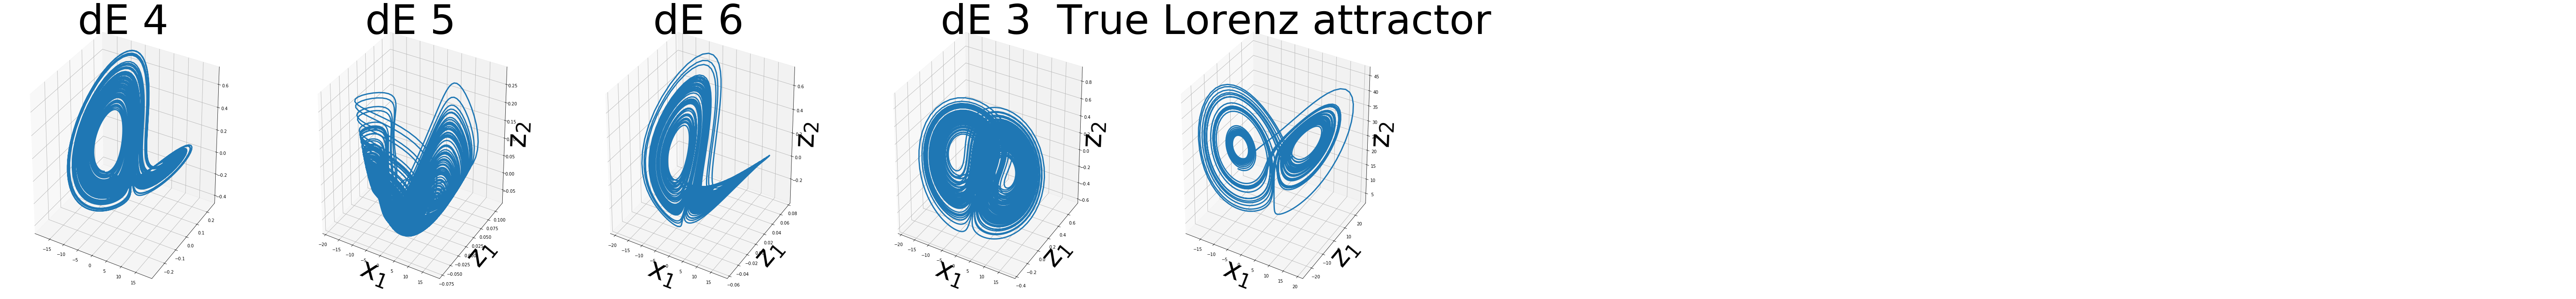

In [38]:
axis_font = 65
title_font = 95


fig = plt.figure(figsize=(70, 70))
ax = fig.add_subplot(5, 6, 4, projection='3d')
line1,=ax.plot(pred_seq_dim[2][0,:,0,0],pred_seq_dim[2][0,:,0,1],pred_seq_dim[2][0,:,0,2],lw = 3)
ax.set_xlabel('$\mathrm{x_1}$', fontsize = axis_font);ax.set_ylabel('$\mathrm{z_1}$', fontsize = axis_font);ax.set_zlabel('$\mathrm{z_2}$', fontsize = axis_font)
plt.title("dE 3",fontsize = title_font)
plt.grid()


ax = fig.add_subplot(5, 6, 1, projection='3d')
line1,=ax.plot(pred_seq_dim[3][0,:,0,0],pred_seq_dim[3][0,:,0,1],pred_seq_dim[3][0,:,0,2],lw = 3)
plt.title("dE 4",fontsize = title_font)
plt.grid()

ax = fig.add_subplot(5, 6, 2, projection='3d')
line1,=ax.plot(pred_seq_dim[4][0,:,0,0],pred_seq_dim[4][0,:,0,1],pred_seq_dim[4][0,:,0,2],lw = 3)
ax.set_xlabel('$\mathrm{x_1}$', fontsize = axis_font);ax.set_ylabel('$\mathrm{z_1}$', fontsize = axis_font);ax.set_zlabel('$\mathrm{z_2}$', fontsize = axis_font)
plt.title("dE 5",fontsize = title_font)
plt.grid()

ax = fig.add_subplot(5, 6, 3, projection='3d')
line1,=ax.plot(pred_seq_dim[5][0,:,0,0],pred_seq_dim[5][0,:,0,1],pred_seq_dim[5][0,:,0,2],lw = 3)
ax.set_xlabel('$\mathrm{x_1}$', fontsize = axis_font);ax.set_ylabel('$\mathrm{z_1}$', fontsize = axis_font);ax.set_zlabel('$\mathrm{z_2}$', fontsize = axis_font)
plt.title("dE 6",fontsize = title_font)
plt.grid()

ax = fig.add_subplot(5, 6, 5, projection='3d')
line1,=ax.plot(Attractor_Lorenz[:,0],Attractor_Lorenz[:,1],Attractor_Lorenz[:,2],lw = 3)
ax.set_xlabel('$\mathrm{x_1}$', fontsize = axis_font);ax.set_ylabel('$\mathrm{z_1}$', fontsize = axis_font);ax.set_zlabel('$\mathrm{z_2}$', fontsize = axis_font)
plt.title("True Lorenz attractor",fontsize = title_font)
plt.grid()

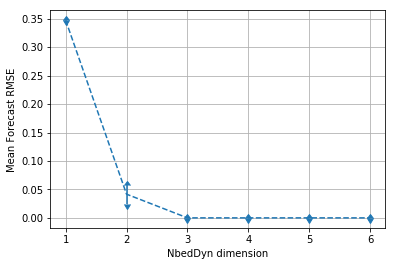

In [29]:
mean_per_dim_train = np.zeros(len(train_loss_dim))
std_per_dim_train  = np.zeros(len(train_loss_dim))
mean_per_dim_test  = np.zeros(len(train_loss_dim))
std_per_dim_test   = np.zeros(len(train_loss_dim))
mean_per_dim_lyap_dim = np.zeros(len(train_loss_dim))
std_per_dim_lyap_dim  = np.zeros(len(train_loss_dim))
mean_per_dim_lyap_larg = np.zeros(len(train_loss_dim))
std_per_dim_lyap_larg  = np.zeros(len(train_loss_dim))

for i in range(mean_per_dim_train.shape[0]):
    
    mean_per_dim_test[i] = np.nanmean(forecast_error_dim[i])
    std_per_dim_test[i] = np.nanstd(forecast_error_dim[i])
    
    mean_per_dim_lyap_dim[i] = np.nanmean(lyap_dim_dim[i])
    std_per_dim_lyap_dim[i] = np.nanstd(lyap_dim_dim[i])
    
    mean_per_dim_lyap_larg[i] = np.nanmean(largest_lyap_dim[i])
    std_per_dim_lyap_larg[i] = np.nanstd(largest_lyap_dim[i])
x = np.arange(1,7)
plt.errorbar(x, mean_per_dim_test,std_per_dim_test,linestyle='--', uplims=True, lolims=True)
plt.xlabel('NbedDyn dimension')
plt.ylabel('Mean Forecast RMSE')
plt.grid()
plt.show()

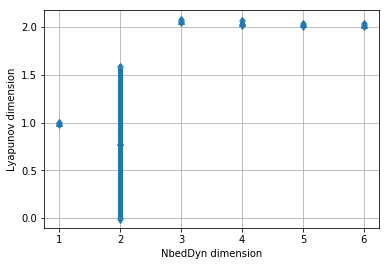

In [30]:
x = np.arange(1,7)
plt.errorbar(x, mean_per_dim_lyap_dim,std_per_dim_lyap_dim, linestyle='None', marker='^', uplims=True, lolims=True,lw = 5)
plt.xlabel('NbedDyn dimension')
plt.ylabel('Lyapunov dimension')
plt.grid()
plt.show()

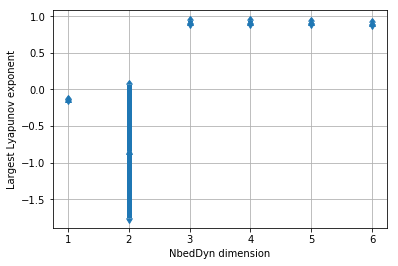

In [31]:
x = np.arange(1,7)
plt.errorbar(x, mean_per_dim_lyap_larg,std_per_dim_lyap_larg, linestyle='None', marker='^', uplims=True, lolims=True, lw = 5)
plt.xlabel('NbedDyn dimension')
plt.ylabel('Largest Lyapunov exponent')
plt.grid()
plt.show()

# Project embedding into the True Lorenz 63 attractor

In [32]:
dim_to_load = 6
seed = 0
file_to_load= 'NbedDyn_L63_dim_'+str(dim_to_load)+'_seed_'+str(seed)+'.pt'
modelRINN.load_state_dict(torch.load(params['path'] + file_to_load))
aug_inp = torch.cat((torch.from_numpy(X_train).float()[0,:,:],modelRINN.Dyn_net.y_aug[0,:,:]),dim = -1)
Attractor_Nbed_Dyn = aug_inp.detach().numpy()

In [33]:
class FC_Affine_net(torch.nn.Module):
                    def __init__(self, params):
                        super(FC_Affine_net, self).__init__()
                        self.linearCell   = torch.nn.Linear(dim_to_load , 3) 
                    def forward(self, inp):
                        L_outp   = self.linearCell(inp)
                        return L_outp

In [34]:
Geo_trans  = FC_Affine_net(params)
criterion  = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer  = torch.optim.Adam(Geo_trans.parameters(),lr = 0.1)
inp_affine = torch.from_numpy(Attractor_Nbed_Dyn).float()
out_affine = torch.from_numpy(Attractor_Lorenz[:,:]).float()
aug_transf_data = []
params['ntrain']=[30000,10000]
for t in range(0,params['ntrain'][0]):
                    # Forward pass: Compute predicted y by passing x to the model
                    pred = Geo_trans(inp_affine)
                    # Compute and print loss
                    loss = criterion(pred, out_affine)
                    aug_transf_data.append(pred.detach().data.numpy())
                    print(t,loss)
                    # Zero gradients, perform a backward pass, and update the weights.
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    optimizer.step()

/data/anaconda/envs/py35/lib/python3.5/site-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(242.8872, grad_fn=<MseLossBackward>)
1 tensor(233.4535, grad_fn=<MseLossBackward>)
2 tensor(225.3883, grad_fn=<MseLossBackward>)
3 tensor(218.6920, grad_fn=<MseLossBackward>)
4 tensor(213.3264, grad_fn=<MseLossBackward>)
5 tensor(209.2025, grad_fn=<MseLossBackward>)
6 tensor(206.1740, grad_fn=<MseLossBackward>)
7 tensor(204.0363, grad_fn=<MseLossBackward>)
8 tensor(202.5363, grad_fn=<MseLossBackward>)
9 tensor(201.4006, grad_fn=<MseLossBackward>)
10 tensor(200.3752, grad_fn=<MseLossBackward>)
11 tensor(199.2622, grad_fn=<MseLossBackward>)
12 tensor(197.9394, grad_fn=<MseLossBackward>)
13 tensor(196.3586, grad_fn=<MseLossBackward>)
14 tensor(194.5320, grad_fn=<MseLossBackward>)
15 tensor(192.5122, grad_fn=<MseLossBackward>)
16 tensor(190.3732, grad_fn=<MseLossBackward>)
17 tensor(188.1937, grad_fn=<MseLossBackward>)
18 tensor(186.0447, grad_fn=<MseLossBackward>)
19 tensor(183.9809, grad_fn=<MseLossBackward>)
20 tensor(182.0361, grad_fn=<MseLossBackward>)
21 tensor(180.2218, gra

260 tensor(12.6300, grad_fn=<MseLossBackward>)
261 tensor(12.4734, grad_fn=<MseLossBackward>)
262 tensor(12.3188, grad_fn=<MseLossBackward>)
263 tensor(12.1662, grad_fn=<MseLossBackward>)
264 tensor(12.0155, grad_fn=<MseLossBackward>)
265 tensor(11.8668, grad_fn=<MseLossBackward>)
266 tensor(11.7199, grad_fn=<MseLossBackward>)
267 tensor(11.5750, grad_fn=<MseLossBackward>)
268 tensor(11.4319, grad_fn=<MseLossBackward>)
269 tensor(11.2906, grad_fn=<MseLossBackward>)
270 tensor(11.1512, grad_fn=<MseLossBackward>)
271 tensor(11.0135, grad_fn=<MseLossBackward>)
272 tensor(10.8777, grad_fn=<MseLossBackward>)
273 tensor(10.7436, grad_fn=<MseLossBackward>)
274 tensor(10.6113, grad_fn=<MseLossBackward>)
275 tensor(10.4807, grad_fn=<MseLossBackward>)
276 tensor(10.3518, grad_fn=<MseLossBackward>)
277 tensor(10.2246, grad_fn=<MseLossBackward>)
278 tensor(10.0990, grad_fn=<MseLossBackward>)
279 tensor(9.9752, grad_fn=<MseLossBackward>)
280 tensor(9.8529, grad_fn=<MseLossBackward>)
281 tensor(9.73

511 tensor(1.8375, grad_fn=<MseLossBackward>)
512 tensor(1.8343, grad_fn=<MseLossBackward>)
513 tensor(1.8310, grad_fn=<MseLossBackward>)
514 tensor(1.8278, grad_fn=<MseLossBackward>)
515 tensor(1.8247, grad_fn=<MseLossBackward>)
516 tensor(1.8216, grad_fn=<MseLossBackward>)
517 tensor(1.8186, grad_fn=<MseLossBackward>)
518 tensor(1.8156, grad_fn=<MseLossBackward>)
519 tensor(1.8126, grad_fn=<MseLossBackward>)
520 tensor(1.8097, grad_fn=<MseLossBackward>)
521 tensor(1.8068, grad_fn=<MseLossBackward>)
522 tensor(1.8040, grad_fn=<MseLossBackward>)
523 tensor(1.8012, grad_fn=<MseLossBackward>)
524 tensor(1.7984, grad_fn=<MseLossBackward>)
525 tensor(1.7957, grad_fn=<MseLossBackward>)
526 tensor(1.7930, grad_fn=<MseLossBackward>)
527 tensor(1.7904, grad_fn=<MseLossBackward>)
528 tensor(1.7878, grad_fn=<MseLossBackward>)
529 tensor(1.7852, grad_fn=<MseLossBackward>)
530 tensor(1.7827, grad_fn=<MseLossBackward>)
531 tensor(1.7802, grad_fn=<MseLossBackward>)
532 tensor(1.7777, grad_fn=<MseLos

851 tensor(1.4336, grad_fn=<MseLossBackward>)
852 tensor(1.4328, grad_fn=<MseLossBackward>)
853 tensor(1.4320, grad_fn=<MseLossBackward>)
854 tensor(1.4312, grad_fn=<MseLossBackward>)
855 tensor(1.4305, grad_fn=<MseLossBackward>)
856 tensor(1.4297, grad_fn=<MseLossBackward>)
857 tensor(1.4289, grad_fn=<MseLossBackward>)
858 tensor(1.4281, grad_fn=<MseLossBackward>)
859 tensor(1.4273, grad_fn=<MseLossBackward>)
860 tensor(1.4266, grad_fn=<MseLossBackward>)
861 tensor(1.4258, grad_fn=<MseLossBackward>)
862 tensor(1.4250, grad_fn=<MseLossBackward>)
863 tensor(1.4242, grad_fn=<MseLossBackward>)
864 tensor(1.4235, grad_fn=<MseLossBackward>)
865 tensor(1.4227, grad_fn=<MseLossBackward>)
866 tensor(1.4219, grad_fn=<MseLossBackward>)
867 tensor(1.4211, grad_fn=<MseLossBackward>)
868 tensor(1.4204, grad_fn=<MseLossBackward>)
869 tensor(1.4196, grad_fn=<MseLossBackward>)
870 tensor(1.4188, grad_fn=<MseLossBackward>)
871 tensor(1.4181, grad_fn=<MseLossBackward>)
872 tensor(1.4173, grad_fn=<MseLos

1111 tensor(1.2503, grad_fn=<MseLossBackward>)
1112 tensor(1.2496, grad_fn=<MseLossBackward>)
1113 tensor(1.2490, grad_fn=<MseLossBackward>)
1114 tensor(1.2484, grad_fn=<MseLossBackward>)
1115 tensor(1.2478, grad_fn=<MseLossBackward>)
1116 tensor(1.2471, grad_fn=<MseLossBackward>)
1117 tensor(1.2465, grad_fn=<MseLossBackward>)
1118 tensor(1.2459, grad_fn=<MseLossBackward>)
1119 tensor(1.2453, grad_fn=<MseLossBackward>)
1120 tensor(1.2446, grad_fn=<MseLossBackward>)
1121 tensor(1.2440, grad_fn=<MseLossBackward>)
1122 tensor(1.2434, grad_fn=<MseLossBackward>)
1123 tensor(1.2428, grad_fn=<MseLossBackward>)
1124 tensor(1.2421, grad_fn=<MseLossBackward>)
1125 tensor(1.2415, grad_fn=<MseLossBackward>)
1126 tensor(1.2409, grad_fn=<MseLossBackward>)
1127 tensor(1.2403, grad_fn=<MseLossBackward>)
1128 tensor(1.2397, grad_fn=<MseLossBackward>)
1129 tensor(1.2390, grad_fn=<MseLossBackward>)
1130 tensor(1.2384, grad_fn=<MseLossBackward>)
1131 tensor(1.2378, grad_fn=<MseLossBackward>)
1132 tensor(1

1346 tensor(1.1179, grad_fn=<MseLossBackward>)
1347 tensor(1.1174, grad_fn=<MseLossBackward>)
1348 tensor(1.1169, grad_fn=<MseLossBackward>)
1349 tensor(1.1164, grad_fn=<MseLossBackward>)
1350 tensor(1.1159, grad_fn=<MseLossBackward>)
1351 tensor(1.1154, grad_fn=<MseLossBackward>)
1352 tensor(1.1149, grad_fn=<MseLossBackward>)
1353 tensor(1.1144, grad_fn=<MseLossBackward>)
1354 tensor(1.1139, grad_fn=<MseLossBackward>)
1355 tensor(1.1134, grad_fn=<MseLossBackward>)
1356 tensor(1.1129, grad_fn=<MseLossBackward>)
1357 tensor(1.1124, grad_fn=<MseLossBackward>)
1358 tensor(1.1119, grad_fn=<MseLossBackward>)
1359 tensor(1.1115, grad_fn=<MseLossBackward>)
1360 tensor(1.1110, grad_fn=<MseLossBackward>)
1361 tensor(1.1105, grad_fn=<MseLossBackward>)
1362 tensor(1.1100, grad_fn=<MseLossBackward>)
1363 tensor(1.1095, grad_fn=<MseLossBackward>)
1364 tensor(1.1090, grad_fn=<MseLossBackward>)
1365 tensor(1.1085, grad_fn=<MseLossBackward>)
1366 tensor(1.1080, grad_fn=<MseLossBackward>)
1367 tensor(1

1583 tensor(1.0137, grad_fn=<MseLossBackward>)
1584 tensor(1.0133, grad_fn=<MseLossBackward>)
1585 tensor(1.0130, grad_fn=<MseLossBackward>)
1586 tensor(1.0126, grad_fn=<MseLossBackward>)
1587 tensor(1.0122, grad_fn=<MseLossBackward>)
1588 tensor(1.0118, grad_fn=<MseLossBackward>)
1589 tensor(1.0114, grad_fn=<MseLossBackward>)
1590 tensor(1.0111, grad_fn=<MseLossBackward>)
1591 tensor(1.0107, grad_fn=<MseLossBackward>)
1592 tensor(1.0103, grad_fn=<MseLossBackward>)
1593 tensor(1.0099, grad_fn=<MseLossBackward>)
1594 tensor(1.0096, grad_fn=<MseLossBackward>)
1595 tensor(1.0092, grad_fn=<MseLossBackward>)
1596 tensor(1.0088, grad_fn=<MseLossBackward>)
1597 tensor(1.0084, grad_fn=<MseLossBackward>)
1598 tensor(1.0081, grad_fn=<MseLossBackward>)
1599 tensor(1.0077, grad_fn=<MseLossBackward>)
1600 tensor(1.0073, grad_fn=<MseLossBackward>)
1601 tensor(1.0069, grad_fn=<MseLossBackward>)
1602 tensor(1.0066, grad_fn=<MseLossBackward>)
1603 tensor(1.0062, grad_fn=<MseLossBackward>)
1604 tensor(1

1819 tensor(0.9358, grad_fn=<MseLossBackward>)
1820 tensor(0.9355, grad_fn=<MseLossBackward>)
1821 tensor(0.9352, grad_fn=<MseLossBackward>)
1822 tensor(0.9349, grad_fn=<MseLossBackward>)
1823 tensor(0.9346, grad_fn=<MseLossBackward>)
1824 tensor(0.9344, grad_fn=<MseLossBackward>)
1825 tensor(0.9341, grad_fn=<MseLossBackward>)
1826 tensor(0.9338, grad_fn=<MseLossBackward>)
1827 tensor(0.9335, grad_fn=<MseLossBackward>)
1828 tensor(0.9332, grad_fn=<MseLossBackward>)
1829 tensor(0.9330, grad_fn=<MseLossBackward>)
1830 tensor(0.9327, grad_fn=<MseLossBackward>)
1831 tensor(0.9324, grad_fn=<MseLossBackward>)
1832 tensor(0.9321, grad_fn=<MseLossBackward>)
1833 tensor(0.9319, grad_fn=<MseLossBackward>)
1834 tensor(0.9316, grad_fn=<MseLossBackward>)
1835 tensor(0.9313, grad_fn=<MseLossBackward>)
1836 tensor(0.9310, grad_fn=<MseLossBackward>)
1837 tensor(0.9307, grad_fn=<MseLossBackward>)
1838 tensor(0.9305, grad_fn=<MseLossBackward>)
1839 tensor(0.9302, grad_fn=<MseLossBackward>)
1840 tensor(0

2054 tensor(0.8797, grad_fn=<MseLossBackward>)
2055 tensor(0.8795, grad_fn=<MseLossBackward>)
2056 tensor(0.8793, grad_fn=<MseLossBackward>)
2057 tensor(0.8791, grad_fn=<MseLossBackward>)
2058 tensor(0.8789, grad_fn=<MseLossBackward>)
2059 tensor(0.8787, grad_fn=<MseLossBackward>)
2060 tensor(0.8785, grad_fn=<MseLossBackward>)
2061 tensor(0.8783, grad_fn=<MseLossBackward>)
2062 tensor(0.8781, grad_fn=<MseLossBackward>)
2063 tensor(0.8779, grad_fn=<MseLossBackward>)
2064 tensor(0.8777, grad_fn=<MseLossBackward>)
2065 tensor(0.8775, grad_fn=<MseLossBackward>)
2066 tensor(0.8773, grad_fn=<MseLossBackward>)
2067 tensor(0.8771, grad_fn=<MseLossBackward>)
2068 tensor(0.8769, grad_fn=<MseLossBackward>)
2069 tensor(0.8767, grad_fn=<MseLossBackward>)
2070 tensor(0.8765, grad_fn=<MseLossBackward>)
2071 tensor(0.8763, grad_fn=<MseLossBackward>)
2072 tensor(0.8761, grad_fn=<MseLossBackward>)
2073 tensor(0.8759, grad_fn=<MseLossBackward>)
2074 tensor(0.8757, grad_fn=<MseLossBackward>)
2075 tensor(0

2230 tensor(0.8492, grad_fn=<MseLossBackward>)
2231 tensor(0.8491, grad_fn=<MseLossBackward>)
2232 tensor(0.8489, grad_fn=<MseLossBackward>)
2233 tensor(0.8488, grad_fn=<MseLossBackward>)
2234 tensor(0.8486, grad_fn=<MseLossBackward>)
2235 tensor(0.8485, grad_fn=<MseLossBackward>)
2236 tensor(0.8483, grad_fn=<MseLossBackward>)
2237 tensor(0.8482, grad_fn=<MseLossBackward>)
2238 tensor(0.8481, grad_fn=<MseLossBackward>)
2239 tensor(0.8479, grad_fn=<MseLossBackward>)
2240 tensor(0.8478, grad_fn=<MseLossBackward>)
2241 tensor(0.8476, grad_fn=<MseLossBackward>)
2242 tensor(0.8475, grad_fn=<MseLossBackward>)
2243 tensor(0.8473, grad_fn=<MseLossBackward>)
2244 tensor(0.8472, grad_fn=<MseLossBackward>)
2245 tensor(0.8470, grad_fn=<MseLossBackward>)
2246 tensor(0.8469, grad_fn=<MseLossBackward>)
2247 tensor(0.8467, grad_fn=<MseLossBackward>)
2248 tensor(0.8466, grad_fn=<MseLossBackward>)
2249 tensor(0.8465, grad_fn=<MseLossBackward>)
2250 tensor(0.8463, grad_fn=<MseLossBackward>)
2251 tensor(0

2456 tensor(0.8217, grad_fn=<MseLossBackward>)
2457 tensor(0.8216, grad_fn=<MseLossBackward>)
2458 tensor(0.8215, grad_fn=<MseLossBackward>)
2459 tensor(0.8214, grad_fn=<MseLossBackward>)
2460 tensor(0.8213, grad_fn=<MseLossBackward>)
2461 tensor(0.8212, grad_fn=<MseLossBackward>)
2462 tensor(0.8211, grad_fn=<MseLossBackward>)
2463 tensor(0.8210, grad_fn=<MseLossBackward>)
2464 tensor(0.8209, grad_fn=<MseLossBackward>)
2465 tensor(0.8208, grad_fn=<MseLossBackward>)
2466 tensor(0.8207, grad_fn=<MseLossBackward>)
2467 tensor(0.8206, grad_fn=<MseLossBackward>)
2468 tensor(0.8206, grad_fn=<MseLossBackward>)
2469 tensor(0.8205, grad_fn=<MseLossBackward>)
2470 tensor(0.8204, grad_fn=<MseLossBackward>)
2471 tensor(0.8203, grad_fn=<MseLossBackward>)
2472 tensor(0.8202, grad_fn=<MseLossBackward>)
2473 tensor(0.8201, grad_fn=<MseLossBackward>)
2474 tensor(0.8200, grad_fn=<MseLossBackward>)
2475 tensor(0.8199, grad_fn=<MseLossBackward>)
2476 tensor(0.8198, grad_fn=<MseLossBackward>)
2477 tensor(0

2637 tensor(0.8069, grad_fn=<MseLossBackward>)
2638 tensor(0.8069, grad_fn=<MseLossBackward>)
2639 tensor(0.8068, grad_fn=<MseLossBackward>)
2640 tensor(0.8067, grad_fn=<MseLossBackward>)
2641 tensor(0.8067, grad_fn=<MseLossBackward>)
2642 tensor(0.8066, grad_fn=<MseLossBackward>)
2643 tensor(0.8065, grad_fn=<MseLossBackward>)
2644 tensor(0.8065, grad_fn=<MseLossBackward>)
2645 tensor(0.8064, grad_fn=<MseLossBackward>)
2646 tensor(0.8063, grad_fn=<MseLossBackward>)
2647 tensor(0.8063, grad_fn=<MseLossBackward>)
2648 tensor(0.8062, grad_fn=<MseLossBackward>)
2649 tensor(0.8062, grad_fn=<MseLossBackward>)
2650 tensor(0.8061, grad_fn=<MseLossBackward>)
2651 tensor(0.8060, grad_fn=<MseLossBackward>)
2652 tensor(0.8060, grad_fn=<MseLossBackward>)
2653 tensor(0.8059, grad_fn=<MseLossBackward>)
2654 tensor(0.8058, grad_fn=<MseLossBackward>)
2655 tensor(0.8058, grad_fn=<MseLossBackward>)
2656 tensor(0.8057, grad_fn=<MseLossBackward>)
2657 tensor(0.8056, grad_fn=<MseLossBackward>)
2658 tensor(0

2958 tensor(0.7918, grad_fn=<MseLossBackward>)
2959 tensor(0.7918, grad_fn=<MseLossBackward>)
2960 tensor(0.7917, grad_fn=<MseLossBackward>)
2961 tensor(0.7917, grad_fn=<MseLossBackward>)
2962 tensor(0.7917, grad_fn=<MseLossBackward>)
2963 tensor(0.7916, grad_fn=<MseLossBackward>)
2964 tensor(0.7916, grad_fn=<MseLossBackward>)
2965 tensor(0.7916, grad_fn=<MseLossBackward>)
2966 tensor(0.7915, grad_fn=<MseLossBackward>)
2967 tensor(0.7915, grad_fn=<MseLossBackward>)
2968 tensor(0.7915, grad_fn=<MseLossBackward>)
2969 tensor(0.7915, grad_fn=<MseLossBackward>)
2970 tensor(0.7914, grad_fn=<MseLossBackward>)
2971 tensor(0.7914, grad_fn=<MseLossBackward>)
2972 tensor(0.7914, grad_fn=<MseLossBackward>)
2973 tensor(0.7913, grad_fn=<MseLossBackward>)
2974 tensor(0.7913, grad_fn=<MseLossBackward>)
2975 tensor(0.7913, grad_fn=<MseLossBackward>)
2976 tensor(0.7912, grad_fn=<MseLossBackward>)
2977 tensor(0.7912, grad_fn=<MseLossBackward>)
2978 tensor(0.7912, grad_fn=<MseLossBackward>)
2979 tensor(0

3293 tensor(0.7850, grad_fn=<MseLossBackward>)
3294 tensor(0.7850, grad_fn=<MseLossBackward>)
3295 tensor(0.7850, grad_fn=<MseLossBackward>)
3296 tensor(0.7850, grad_fn=<MseLossBackward>)
3297 tensor(0.7850, grad_fn=<MseLossBackward>)
3298 tensor(0.7850, grad_fn=<MseLossBackward>)
3299 tensor(0.7850, grad_fn=<MseLossBackward>)
3300 tensor(0.7850, grad_fn=<MseLossBackward>)
3301 tensor(0.7849, grad_fn=<MseLossBackward>)
3302 tensor(0.7849, grad_fn=<MseLossBackward>)
3303 tensor(0.7849, grad_fn=<MseLossBackward>)
3304 tensor(0.7849, grad_fn=<MseLossBackward>)
3305 tensor(0.7849, grad_fn=<MseLossBackward>)
3306 tensor(0.7849, grad_fn=<MseLossBackward>)
3307 tensor(0.7849, grad_fn=<MseLossBackward>)
3308 tensor(0.7849, grad_fn=<MseLossBackward>)
3309 tensor(0.7848, grad_fn=<MseLossBackward>)
3310 tensor(0.7848, grad_fn=<MseLossBackward>)
3311 tensor(0.7848, grad_fn=<MseLossBackward>)
3312 tensor(0.7848, grad_fn=<MseLossBackward>)
3313 tensor(0.7848, grad_fn=<MseLossBackward>)
3314 tensor(0

3527 tensor(0.7831, grad_fn=<MseLossBackward>)
3528 tensor(0.7831, grad_fn=<MseLossBackward>)
3529 tensor(0.7831, grad_fn=<MseLossBackward>)
3530 tensor(0.7831, grad_fn=<MseLossBackward>)
3531 tensor(0.7831, grad_fn=<MseLossBackward>)
3532 tensor(0.7831, grad_fn=<MseLossBackward>)
3533 tensor(0.7831, grad_fn=<MseLossBackward>)
3534 tensor(0.7831, grad_fn=<MseLossBackward>)
3535 tensor(0.7831, grad_fn=<MseLossBackward>)
3536 tensor(0.7830, grad_fn=<MseLossBackward>)
3537 tensor(0.7830, grad_fn=<MseLossBackward>)
3538 tensor(0.7830, grad_fn=<MseLossBackward>)
3539 tensor(0.7830, grad_fn=<MseLossBackward>)
3540 tensor(0.7830, grad_fn=<MseLossBackward>)
3541 tensor(0.7830, grad_fn=<MseLossBackward>)
3542 tensor(0.7830, grad_fn=<MseLossBackward>)
3543 tensor(0.7830, grad_fn=<MseLossBackward>)
3544 tensor(0.7830, grad_fn=<MseLossBackward>)
3545 tensor(0.7830, grad_fn=<MseLossBackward>)
3546 tensor(0.7830, grad_fn=<MseLossBackward>)
3547 tensor(0.7830, grad_fn=<MseLossBackward>)
3548 tensor(0

3741 tensor(0.7823, grad_fn=<MseLossBackward>)
3742 tensor(0.7823, grad_fn=<MseLossBackward>)
3743 tensor(0.7823, grad_fn=<MseLossBackward>)
3744 tensor(0.7823, grad_fn=<MseLossBackward>)
3745 tensor(0.7823, grad_fn=<MseLossBackward>)
3746 tensor(0.7823, grad_fn=<MseLossBackward>)
3747 tensor(0.7823, grad_fn=<MseLossBackward>)
3748 tensor(0.7823, grad_fn=<MseLossBackward>)
3749 tensor(0.7823, grad_fn=<MseLossBackward>)
3750 tensor(0.7823, grad_fn=<MseLossBackward>)
3751 tensor(0.7823, grad_fn=<MseLossBackward>)
3752 tensor(0.7823, grad_fn=<MseLossBackward>)
3753 tensor(0.7823, grad_fn=<MseLossBackward>)
3754 tensor(0.7823, grad_fn=<MseLossBackward>)
3755 tensor(0.7822, grad_fn=<MseLossBackward>)
3756 tensor(0.7822, grad_fn=<MseLossBackward>)
3757 tensor(0.7822, grad_fn=<MseLossBackward>)
3758 tensor(0.7822, grad_fn=<MseLossBackward>)
3759 tensor(0.7822, grad_fn=<MseLossBackward>)
3760 tensor(0.7822, grad_fn=<MseLossBackward>)
3761 tensor(0.7822, grad_fn=<MseLossBackward>)
3762 tensor(0

3948 tensor(0.7819, grad_fn=<MseLossBackward>)
3949 tensor(0.7819, grad_fn=<MseLossBackward>)
3950 tensor(0.7819, grad_fn=<MseLossBackward>)
3951 tensor(0.7819, grad_fn=<MseLossBackward>)
3952 tensor(0.7819, grad_fn=<MseLossBackward>)
3953 tensor(0.7819, grad_fn=<MseLossBackward>)
3954 tensor(0.7819, grad_fn=<MseLossBackward>)
3955 tensor(0.7819, grad_fn=<MseLossBackward>)
3956 tensor(0.7819, grad_fn=<MseLossBackward>)
3957 tensor(0.7819, grad_fn=<MseLossBackward>)
3958 tensor(0.7819, grad_fn=<MseLossBackward>)
3959 tensor(0.7819, grad_fn=<MseLossBackward>)
3960 tensor(0.7819, grad_fn=<MseLossBackward>)
3961 tensor(0.7819, grad_fn=<MseLossBackward>)
3962 tensor(0.7819, grad_fn=<MseLossBackward>)
3963 tensor(0.7819, grad_fn=<MseLossBackward>)
3964 tensor(0.7819, grad_fn=<MseLossBackward>)
3965 tensor(0.7819, grad_fn=<MseLossBackward>)
3966 tensor(0.7819, grad_fn=<MseLossBackward>)
3967 tensor(0.7819, grad_fn=<MseLossBackward>)
3968 tensor(0.7819, grad_fn=<MseLossBackward>)
3969 tensor(0

4176 tensor(0.7818, grad_fn=<MseLossBackward>)
4177 tensor(0.7818, grad_fn=<MseLossBackward>)
4178 tensor(0.7818, grad_fn=<MseLossBackward>)
4179 tensor(0.7818, grad_fn=<MseLossBackward>)
4180 tensor(0.7818, grad_fn=<MseLossBackward>)
4181 tensor(0.7818, grad_fn=<MseLossBackward>)
4182 tensor(0.7818, grad_fn=<MseLossBackward>)
4183 tensor(0.7818, grad_fn=<MseLossBackward>)
4184 tensor(0.7818, grad_fn=<MseLossBackward>)
4185 tensor(0.7818, grad_fn=<MseLossBackward>)
4186 tensor(0.7818, grad_fn=<MseLossBackward>)
4187 tensor(0.7818, grad_fn=<MseLossBackward>)
4188 tensor(0.7818, grad_fn=<MseLossBackward>)
4189 tensor(0.7818, grad_fn=<MseLossBackward>)
4190 tensor(0.7817, grad_fn=<MseLossBackward>)
4191 tensor(0.7817, grad_fn=<MseLossBackward>)
4192 tensor(0.7817, grad_fn=<MseLossBackward>)
4193 tensor(0.7817, grad_fn=<MseLossBackward>)
4194 tensor(0.7817, grad_fn=<MseLossBackward>)
4195 tensor(0.7817, grad_fn=<MseLossBackward>)
4196 tensor(0.7817, grad_fn=<MseLossBackward>)
4197 tensor(0

4376 tensor(0.7817, grad_fn=<MseLossBackward>)
4377 tensor(0.7817, grad_fn=<MseLossBackward>)
4378 tensor(0.7817, grad_fn=<MseLossBackward>)
4379 tensor(0.7817, grad_fn=<MseLossBackward>)
4380 tensor(0.7817, grad_fn=<MseLossBackward>)
4381 tensor(0.7817, grad_fn=<MseLossBackward>)
4382 tensor(0.7817, grad_fn=<MseLossBackward>)
4383 tensor(0.7817, grad_fn=<MseLossBackward>)
4384 tensor(0.7817, grad_fn=<MseLossBackward>)
4385 tensor(0.7817, grad_fn=<MseLossBackward>)
4386 tensor(0.7817, grad_fn=<MseLossBackward>)
4387 tensor(0.7817, grad_fn=<MseLossBackward>)
4388 tensor(0.7817, grad_fn=<MseLossBackward>)
4389 tensor(0.7817, grad_fn=<MseLossBackward>)
4390 tensor(0.7817, grad_fn=<MseLossBackward>)
4391 tensor(0.7817, grad_fn=<MseLossBackward>)
4392 tensor(0.7817, grad_fn=<MseLossBackward>)
4393 tensor(0.7817, grad_fn=<MseLossBackward>)
4394 tensor(0.7817, grad_fn=<MseLossBackward>)
4395 tensor(0.7817, grad_fn=<MseLossBackward>)
4396 tensor(0.7817, grad_fn=<MseLossBackward>)
4397 tensor(0

4574 tensor(0.7816, grad_fn=<MseLossBackward>)
4575 tensor(0.7816, grad_fn=<MseLossBackward>)
4576 tensor(0.7816, grad_fn=<MseLossBackward>)
4577 tensor(0.7816, grad_fn=<MseLossBackward>)
4578 tensor(0.7816, grad_fn=<MseLossBackward>)
4579 tensor(0.7816, grad_fn=<MseLossBackward>)
4580 tensor(0.7816, grad_fn=<MseLossBackward>)
4581 tensor(0.7816, grad_fn=<MseLossBackward>)
4582 tensor(0.7816, grad_fn=<MseLossBackward>)
4583 tensor(0.7816, grad_fn=<MseLossBackward>)
4584 tensor(0.7816, grad_fn=<MseLossBackward>)
4585 tensor(0.7816, grad_fn=<MseLossBackward>)
4586 tensor(0.7816, grad_fn=<MseLossBackward>)
4587 tensor(0.7816, grad_fn=<MseLossBackward>)
4588 tensor(0.7816, grad_fn=<MseLossBackward>)
4589 tensor(0.7816, grad_fn=<MseLossBackward>)
4590 tensor(0.7816, grad_fn=<MseLossBackward>)
4591 tensor(0.7816, grad_fn=<MseLossBackward>)
4592 tensor(0.7816, grad_fn=<MseLossBackward>)
4593 tensor(0.7816, grad_fn=<MseLossBackward>)
4594 tensor(0.7816, grad_fn=<MseLossBackward>)
4595 tensor(0

4761 tensor(0.7816, grad_fn=<MseLossBackward>)
4762 tensor(0.7816, grad_fn=<MseLossBackward>)
4763 tensor(0.7816, grad_fn=<MseLossBackward>)
4764 tensor(0.7816, grad_fn=<MseLossBackward>)
4765 tensor(0.7816, grad_fn=<MseLossBackward>)
4766 tensor(0.7816, grad_fn=<MseLossBackward>)
4767 tensor(0.7816, grad_fn=<MseLossBackward>)
4768 tensor(0.7816, grad_fn=<MseLossBackward>)
4769 tensor(0.7816, grad_fn=<MseLossBackward>)
4770 tensor(0.7816, grad_fn=<MseLossBackward>)
4771 tensor(0.7816, grad_fn=<MseLossBackward>)
4772 tensor(0.7816, grad_fn=<MseLossBackward>)
4773 tensor(0.7816, grad_fn=<MseLossBackward>)
4774 tensor(0.7816, grad_fn=<MseLossBackward>)
4775 tensor(0.7816, grad_fn=<MseLossBackward>)
4776 tensor(0.7816, grad_fn=<MseLossBackward>)
4777 tensor(0.7816, grad_fn=<MseLossBackward>)
4778 tensor(0.7816, grad_fn=<MseLossBackward>)
4779 tensor(0.7816, grad_fn=<MseLossBackward>)
4780 tensor(0.7816, grad_fn=<MseLossBackward>)
4781 tensor(0.7816, grad_fn=<MseLossBackward>)
4782 tensor(0

4969 tensor(0.7816, grad_fn=<MseLossBackward>)
4970 tensor(0.7816, grad_fn=<MseLossBackward>)
4971 tensor(0.7816, grad_fn=<MseLossBackward>)
4972 tensor(0.7816, grad_fn=<MseLossBackward>)
4973 tensor(0.7816, grad_fn=<MseLossBackward>)
4974 tensor(0.7816, grad_fn=<MseLossBackward>)
4975 tensor(0.7816, grad_fn=<MseLossBackward>)
4976 tensor(0.7816, grad_fn=<MseLossBackward>)
4977 tensor(0.7816, grad_fn=<MseLossBackward>)
4978 tensor(0.7816, grad_fn=<MseLossBackward>)
4979 tensor(0.7816, grad_fn=<MseLossBackward>)
4980 tensor(0.7816, grad_fn=<MseLossBackward>)
4981 tensor(0.7816, grad_fn=<MseLossBackward>)
4982 tensor(0.7816, grad_fn=<MseLossBackward>)
4983 tensor(0.7816, grad_fn=<MseLossBackward>)
4984 tensor(0.7816, grad_fn=<MseLossBackward>)
4985 tensor(0.7816, grad_fn=<MseLossBackward>)
4986 tensor(0.7816, grad_fn=<MseLossBackward>)
4987 tensor(0.7816, grad_fn=<MseLossBackward>)
4988 tensor(0.7816, grad_fn=<MseLossBackward>)
4989 tensor(0.7816, grad_fn=<MseLossBackward>)
4990 tensor(0

5170 tensor(0.7816, grad_fn=<MseLossBackward>)
5171 tensor(0.7816, grad_fn=<MseLossBackward>)
5172 tensor(0.7816, grad_fn=<MseLossBackward>)
5173 tensor(0.7816, grad_fn=<MseLossBackward>)
5174 tensor(0.7816, grad_fn=<MseLossBackward>)
5175 tensor(0.7816, grad_fn=<MseLossBackward>)
5176 tensor(0.7816, grad_fn=<MseLossBackward>)
5177 tensor(0.7816, grad_fn=<MseLossBackward>)
5178 tensor(0.7816, grad_fn=<MseLossBackward>)
5179 tensor(0.7816, grad_fn=<MseLossBackward>)
5180 tensor(0.7816, grad_fn=<MseLossBackward>)
5181 tensor(0.7816, grad_fn=<MseLossBackward>)
5182 tensor(0.7816, grad_fn=<MseLossBackward>)
5183 tensor(0.7816, grad_fn=<MseLossBackward>)
5184 tensor(0.7816, grad_fn=<MseLossBackward>)
5185 tensor(0.7816, grad_fn=<MseLossBackward>)
5186 tensor(0.7816, grad_fn=<MseLossBackward>)
5187 tensor(0.7816, grad_fn=<MseLossBackward>)
5188 tensor(0.7816, grad_fn=<MseLossBackward>)
5189 tensor(0.7816, grad_fn=<MseLossBackward>)
5190 tensor(0.7816, grad_fn=<MseLossBackward>)
5191 tensor(0

5378 tensor(0.7816, grad_fn=<MseLossBackward>)
5379 tensor(0.7816, grad_fn=<MseLossBackward>)
5380 tensor(0.7816, grad_fn=<MseLossBackward>)
5381 tensor(0.7817, grad_fn=<MseLossBackward>)
5382 tensor(0.7817, grad_fn=<MseLossBackward>)
5383 tensor(0.7816, grad_fn=<MseLossBackward>)
5384 tensor(0.7816, grad_fn=<MseLossBackward>)
5385 tensor(0.7816, grad_fn=<MseLossBackward>)
5386 tensor(0.7816, grad_fn=<MseLossBackward>)
5387 tensor(0.7816, grad_fn=<MseLossBackward>)
5388 tensor(0.7816, grad_fn=<MseLossBackward>)
5389 tensor(0.7816, grad_fn=<MseLossBackward>)
5390 tensor(0.7816, grad_fn=<MseLossBackward>)
5391 tensor(0.7816, grad_fn=<MseLossBackward>)
5392 tensor(0.7816, grad_fn=<MseLossBackward>)
5393 tensor(0.7816, grad_fn=<MseLossBackward>)
5394 tensor(0.7816, grad_fn=<MseLossBackward>)
5395 tensor(0.7816, grad_fn=<MseLossBackward>)
5396 tensor(0.7816, grad_fn=<MseLossBackward>)
5397 tensor(0.7816, grad_fn=<MseLossBackward>)
5398 tensor(0.7816, grad_fn=<MseLossBackward>)
5399 tensor(0

5586 tensor(0.7816, grad_fn=<MseLossBackward>)
5587 tensor(0.7816, grad_fn=<MseLossBackward>)
5588 tensor(0.7816, grad_fn=<MseLossBackward>)
5589 tensor(0.7816, grad_fn=<MseLossBackward>)
5590 tensor(0.7816, grad_fn=<MseLossBackward>)
5591 tensor(0.7816, grad_fn=<MseLossBackward>)
5592 tensor(0.7816, grad_fn=<MseLossBackward>)
5593 tensor(0.7816, grad_fn=<MseLossBackward>)
5594 tensor(0.7816, grad_fn=<MseLossBackward>)
5595 tensor(0.7816, grad_fn=<MseLossBackward>)
5596 tensor(0.7816, grad_fn=<MseLossBackward>)
5597 tensor(0.7816, grad_fn=<MseLossBackward>)
5598 tensor(0.7816, grad_fn=<MseLossBackward>)
5599 tensor(0.7816, grad_fn=<MseLossBackward>)
5600 tensor(0.7816, grad_fn=<MseLossBackward>)
5601 tensor(0.7816, grad_fn=<MseLossBackward>)
5602 tensor(0.7816, grad_fn=<MseLossBackward>)
5603 tensor(0.7816, grad_fn=<MseLossBackward>)
5604 tensor(0.7817, grad_fn=<MseLossBackward>)
5605 tensor(0.7817, grad_fn=<MseLossBackward>)
5606 tensor(0.7819, grad_fn=<MseLossBackward>)
5607 tensor(0

5797 tensor(0.7818, grad_fn=<MseLossBackward>)
5798 tensor(0.7820, grad_fn=<MseLossBackward>)
5799 tensor(0.7823, grad_fn=<MseLossBackward>)
5800 tensor(0.7827, grad_fn=<MseLossBackward>)
5801 tensor(0.7834, grad_fn=<MseLossBackward>)
5802 tensor(0.7845, grad_fn=<MseLossBackward>)
5803 tensor(0.7857, grad_fn=<MseLossBackward>)
5804 tensor(0.7869, grad_fn=<MseLossBackward>)
5805 tensor(0.7871, grad_fn=<MseLossBackward>)
5806 tensor(0.7859, grad_fn=<MseLossBackward>)
5807 tensor(0.7836, grad_fn=<MseLossBackward>)
5808 tensor(0.7818, grad_fn=<MseLossBackward>)
5809 tensor(0.7817, grad_fn=<MseLossBackward>)
5810 tensor(0.7828, grad_fn=<MseLossBackward>)
5811 tensor(0.7839, grad_fn=<MseLossBackward>)
5812 tensor(0.7838, grad_fn=<MseLossBackward>)
5813 tensor(0.7827, grad_fn=<MseLossBackward>)
5814 tensor(0.7817, grad_fn=<MseLossBackward>)
5815 tensor(0.7817, grad_fn=<MseLossBackward>)
5816 tensor(0.7824, grad_fn=<MseLossBackward>)
5817 tensor(0.7829, grad_fn=<MseLossBackward>)
5818 tensor(0

6013 tensor(0.7815, grad_fn=<MseLossBackward>)
6014 tensor(0.7815, grad_fn=<MseLossBackward>)
6015 tensor(0.7815, grad_fn=<MseLossBackward>)
6016 tensor(0.7815, grad_fn=<MseLossBackward>)
6017 tensor(0.7815, grad_fn=<MseLossBackward>)
6018 tensor(0.7815, grad_fn=<MseLossBackward>)
6019 tensor(0.7815, grad_fn=<MseLossBackward>)
6020 tensor(0.7815, grad_fn=<MseLossBackward>)
6021 tensor(0.7815, grad_fn=<MseLossBackward>)
6022 tensor(0.7815, grad_fn=<MseLossBackward>)
6023 tensor(0.7815, grad_fn=<MseLossBackward>)
6024 tensor(0.7815, grad_fn=<MseLossBackward>)
6025 tensor(0.7815, grad_fn=<MseLossBackward>)
6026 tensor(0.7815, grad_fn=<MseLossBackward>)
6027 tensor(0.7815, grad_fn=<MseLossBackward>)
6028 tensor(0.7815, grad_fn=<MseLossBackward>)
6029 tensor(0.7815, grad_fn=<MseLossBackward>)
6030 tensor(0.7815, grad_fn=<MseLossBackward>)
6031 tensor(0.7815, grad_fn=<MseLossBackward>)
6032 tensor(0.7815, grad_fn=<MseLossBackward>)
6033 tensor(0.7815, grad_fn=<MseLossBackward>)
6034 tensor(0

6223 tensor(0.7815, grad_fn=<MseLossBackward>)
6224 tensor(0.7817, grad_fn=<MseLossBackward>)
6225 tensor(0.7820, grad_fn=<MseLossBackward>)
6226 tensor(0.7819, grad_fn=<MseLossBackward>)
6227 tensor(0.7817, grad_fn=<MseLossBackward>)
6228 tensor(0.7815, grad_fn=<MseLossBackward>)
6229 tensor(0.7816, grad_fn=<MseLossBackward>)
6230 tensor(0.7818, grad_fn=<MseLossBackward>)
6231 tensor(0.7818, grad_fn=<MseLossBackward>)
6232 tensor(0.7816, grad_fn=<MseLossBackward>)
6233 tensor(0.7815, grad_fn=<MseLossBackward>)
6234 tensor(0.7816, grad_fn=<MseLossBackward>)
6235 tensor(0.7817, grad_fn=<MseLossBackward>)
6236 tensor(0.7817, grad_fn=<MseLossBackward>)
6237 tensor(0.7816, grad_fn=<MseLossBackward>)
6238 tensor(0.7815, grad_fn=<MseLossBackward>)
6239 tensor(0.7816, grad_fn=<MseLossBackward>)
6240 tensor(0.7816, grad_fn=<MseLossBackward>)
6241 tensor(0.7816, grad_fn=<MseLossBackward>)
6242 tensor(0.7816, grad_fn=<MseLossBackward>)
6243 tensor(0.7815, grad_fn=<MseLossBackward>)
6244 tensor(0

6425 tensor(0.7815, grad_fn=<MseLossBackward>)
6426 tensor(0.7816, grad_fn=<MseLossBackward>)
6427 tensor(0.7816, grad_fn=<MseLossBackward>)
6428 tensor(0.7816, grad_fn=<MseLossBackward>)
6429 tensor(0.7816, grad_fn=<MseLossBackward>)
6430 tensor(0.7815, grad_fn=<MseLossBackward>)
6431 tensor(0.7816, grad_fn=<MseLossBackward>)
6432 tensor(0.7816, grad_fn=<MseLossBackward>)
6433 tensor(0.7816, grad_fn=<MseLossBackward>)
6434 tensor(0.7816, grad_fn=<MseLossBackward>)
6435 tensor(0.7815, grad_fn=<MseLossBackward>)
6436 tensor(0.7815, grad_fn=<MseLossBackward>)
6437 tensor(0.7816, grad_fn=<MseLossBackward>)
6438 tensor(0.7816, grad_fn=<MseLossBackward>)
6439 tensor(0.7815, grad_fn=<MseLossBackward>)
6440 tensor(0.7815, grad_fn=<MseLossBackward>)
6441 tensor(0.7815, grad_fn=<MseLossBackward>)
6442 tensor(0.7815, grad_fn=<MseLossBackward>)
6443 tensor(0.7816, grad_fn=<MseLossBackward>)
6444 tensor(0.7815, grad_fn=<MseLossBackward>)
6445 tensor(0.7815, grad_fn=<MseLossBackward>)
6446 tensor(0

6627 tensor(0.7815, grad_fn=<MseLossBackward>)
6628 tensor(0.7815, grad_fn=<MseLossBackward>)
6629 tensor(0.7815, grad_fn=<MseLossBackward>)
6630 tensor(0.7815, grad_fn=<MseLossBackward>)
6631 tensor(0.7815, grad_fn=<MseLossBackward>)
6632 tensor(0.7815, grad_fn=<MseLossBackward>)
6633 tensor(0.7815, grad_fn=<MseLossBackward>)
6634 tensor(0.7815, grad_fn=<MseLossBackward>)
6635 tensor(0.7815, grad_fn=<MseLossBackward>)
6636 tensor(0.7815, grad_fn=<MseLossBackward>)
6637 tensor(0.7815, grad_fn=<MseLossBackward>)
6638 tensor(0.7815, grad_fn=<MseLossBackward>)
6639 tensor(0.7815, grad_fn=<MseLossBackward>)
6640 tensor(0.7815, grad_fn=<MseLossBackward>)
6641 tensor(0.7815, grad_fn=<MseLossBackward>)
6642 tensor(0.7815, grad_fn=<MseLossBackward>)
6643 tensor(0.7815, grad_fn=<MseLossBackward>)
6644 tensor(0.7815, grad_fn=<MseLossBackward>)
6645 tensor(0.7815, grad_fn=<MseLossBackward>)
6646 tensor(0.7815, grad_fn=<MseLossBackward>)
6647 tensor(0.7815, grad_fn=<MseLossBackward>)
6648 tensor(0

6833 tensor(0.7816, grad_fn=<MseLossBackward>)
6834 tensor(0.7816, grad_fn=<MseLossBackward>)
6835 tensor(0.7815, grad_fn=<MseLossBackward>)
6836 tensor(0.7815, grad_fn=<MseLossBackward>)
6837 tensor(0.7816, grad_fn=<MseLossBackward>)
6838 tensor(0.7816, grad_fn=<MseLossBackward>)
6839 tensor(0.7816, grad_fn=<MseLossBackward>)
6840 tensor(0.7815, grad_fn=<MseLossBackward>)
6841 tensor(0.7815, grad_fn=<MseLossBackward>)
6842 tensor(0.7815, grad_fn=<MseLossBackward>)
6843 tensor(0.7816, grad_fn=<MseLossBackward>)
6844 tensor(0.7815, grad_fn=<MseLossBackward>)
6845 tensor(0.7815, grad_fn=<MseLossBackward>)
6846 tensor(0.7815, grad_fn=<MseLossBackward>)
6847 tensor(0.7815, grad_fn=<MseLossBackward>)
6848 tensor(0.7815, grad_fn=<MseLossBackward>)
6849 tensor(0.7815, grad_fn=<MseLossBackward>)
6850 tensor(0.7815, grad_fn=<MseLossBackward>)
6851 tensor(0.7815, grad_fn=<MseLossBackward>)
6852 tensor(0.7815, grad_fn=<MseLossBackward>)
6853 tensor(0.7815, grad_fn=<MseLossBackward>)
6854 tensor(0

7046 tensor(0.7815, grad_fn=<MseLossBackward>)
7047 tensor(0.7815, grad_fn=<MseLossBackward>)
7048 tensor(0.7815, grad_fn=<MseLossBackward>)
7049 tensor(0.7815, grad_fn=<MseLossBackward>)
7050 tensor(0.7815, grad_fn=<MseLossBackward>)
7051 tensor(0.7815, grad_fn=<MseLossBackward>)
7052 tensor(0.7815, grad_fn=<MseLossBackward>)
7053 tensor(0.7815, grad_fn=<MseLossBackward>)
7054 tensor(0.7815, grad_fn=<MseLossBackward>)
7055 tensor(0.7815, grad_fn=<MseLossBackward>)
7056 tensor(0.7815, grad_fn=<MseLossBackward>)
7057 tensor(0.7815, grad_fn=<MseLossBackward>)
7058 tensor(0.7815, grad_fn=<MseLossBackward>)
7059 tensor(0.7815, grad_fn=<MseLossBackward>)
7060 tensor(0.7815, grad_fn=<MseLossBackward>)
7061 tensor(0.7815, grad_fn=<MseLossBackward>)
7062 tensor(0.7815, grad_fn=<MseLossBackward>)
7063 tensor(0.7815, grad_fn=<MseLossBackward>)
7064 tensor(0.7815, grad_fn=<MseLossBackward>)
7065 tensor(0.7815, grad_fn=<MseLossBackward>)
7066 tensor(0.7815, grad_fn=<MseLossBackward>)
7067 tensor(0

7256 tensor(0.7823, grad_fn=<MseLossBackward>)
7257 tensor(0.7828, grad_fn=<MseLossBackward>)
7258 tensor(0.7837, grad_fn=<MseLossBackward>)
7259 tensor(0.7851, grad_fn=<MseLossBackward>)
7260 tensor(0.7869, grad_fn=<MseLossBackward>)
7261 tensor(0.7885, grad_fn=<MseLossBackward>)
7262 tensor(0.7886, grad_fn=<MseLossBackward>)
7263 tensor(0.7865, grad_fn=<MseLossBackward>)
7264 tensor(0.7833, grad_fn=<MseLossBackward>)
7265 tensor(0.7816, grad_fn=<MseLossBackward>)
7266 tensor(0.7824, grad_fn=<MseLossBackward>)
7267 tensor(0.7842, grad_fn=<MseLossBackward>)
7268 tensor(0.7848, grad_fn=<MseLossBackward>)
7269 tensor(0.7835, grad_fn=<MseLossBackward>)
7270 tensor(0.7818, grad_fn=<MseLossBackward>)
7271 tensor(0.7817, grad_fn=<MseLossBackward>)
7272 tensor(0.7828, grad_fn=<MseLossBackward>)
7273 tensor(0.7834, grad_fn=<MseLossBackward>)
7274 tensor(0.7827, grad_fn=<MseLossBackward>)
7275 tensor(0.7817, grad_fn=<MseLossBackward>)
7276 tensor(0.7817, grad_fn=<MseLossBackward>)
7277 tensor(0

7462 tensor(0.7815, grad_fn=<MseLossBackward>)
7463 tensor(0.7815, grad_fn=<MseLossBackward>)
7464 tensor(0.7815, grad_fn=<MseLossBackward>)
7465 tensor(0.7815, grad_fn=<MseLossBackward>)
7466 tensor(0.7815, grad_fn=<MseLossBackward>)
7467 tensor(0.7815, grad_fn=<MseLossBackward>)
7468 tensor(0.7815, grad_fn=<MseLossBackward>)
7469 tensor(0.7815, grad_fn=<MseLossBackward>)
7470 tensor(0.7815, grad_fn=<MseLossBackward>)
7471 tensor(0.7815, grad_fn=<MseLossBackward>)
7472 tensor(0.7815, grad_fn=<MseLossBackward>)
7473 tensor(0.7815, grad_fn=<MseLossBackward>)
7474 tensor(0.7815, grad_fn=<MseLossBackward>)
7475 tensor(0.7815, grad_fn=<MseLossBackward>)
7476 tensor(0.7815, grad_fn=<MseLossBackward>)
7477 tensor(0.7815, grad_fn=<MseLossBackward>)
7478 tensor(0.7815, grad_fn=<MseLossBackward>)
7479 tensor(0.7815, grad_fn=<MseLossBackward>)
7480 tensor(0.7815, grad_fn=<MseLossBackward>)
7481 tensor(0.7815, grad_fn=<MseLossBackward>)
7482 tensor(0.7815, grad_fn=<MseLossBackward>)
7483 tensor(0

7665 tensor(0.7815, grad_fn=<MseLossBackward>)
7666 tensor(0.7815, grad_fn=<MseLossBackward>)
7667 tensor(0.7815, grad_fn=<MseLossBackward>)
7668 tensor(0.7815, grad_fn=<MseLossBackward>)
7669 tensor(0.7815, grad_fn=<MseLossBackward>)
7670 tensor(0.7815, grad_fn=<MseLossBackward>)
7671 tensor(0.7815, grad_fn=<MseLossBackward>)
7672 tensor(0.7815, grad_fn=<MseLossBackward>)
7673 tensor(0.7815, grad_fn=<MseLossBackward>)
7674 tensor(0.7815, grad_fn=<MseLossBackward>)
7675 tensor(0.7815, grad_fn=<MseLossBackward>)
7676 tensor(0.7815, grad_fn=<MseLossBackward>)
7677 tensor(0.7815, grad_fn=<MseLossBackward>)
7678 tensor(0.7815, grad_fn=<MseLossBackward>)
7679 tensor(0.7815, grad_fn=<MseLossBackward>)
7680 tensor(0.7815, grad_fn=<MseLossBackward>)
7681 tensor(0.7815, grad_fn=<MseLossBackward>)
7682 tensor(0.7815, grad_fn=<MseLossBackward>)
7683 tensor(0.7815, grad_fn=<MseLossBackward>)
7684 tensor(0.7816, grad_fn=<MseLossBackward>)
7685 tensor(0.7816, grad_fn=<MseLossBackward>)
7686 tensor(0

7865 tensor(0.7816, grad_fn=<MseLossBackward>)
7866 tensor(0.7817, grad_fn=<MseLossBackward>)
7867 tensor(0.7818, grad_fn=<MseLossBackward>)
7868 tensor(0.7817, grad_fn=<MseLossBackward>)
7869 tensor(0.7816, grad_fn=<MseLossBackward>)
7870 tensor(0.7815, grad_fn=<MseLossBackward>)
7871 tensor(0.7816, grad_fn=<MseLossBackward>)
7872 tensor(0.7817, grad_fn=<MseLossBackward>)
7873 tensor(0.7816, grad_fn=<MseLossBackward>)
7874 tensor(0.7816, grad_fn=<MseLossBackward>)
7875 tensor(0.7815, grad_fn=<MseLossBackward>)
7876 tensor(0.7816, grad_fn=<MseLossBackward>)
7877 tensor(0.7816, grad_fn=<MseLossBackward>)
7878 tensor(0.7816, grad_fn=<MseLossBackward>)
7879 tensor(0.7816, grad_fn=<MseLossBackward>)
7880 tensor(0.7815, grad_fn=<MseLossBackward>)
7881 tensor(0.7815, grad_fn=<MseLossBackward>)
7882 tensor(0.7816, grad_fn=<MseLossBackward>)
7883 tensor(0.7816, grad_fn=<MseLossBackward>)
7884 tensor(0.7816, grad_fn=<MseLossBackward>)
7885 tensor(0.7815, grad_fn=<MseLossBackward>)
7886 tensor(0

8079 tensor(0.7815, grad_fn=<MseLossBackward>)
8080 tensor(0.7815, grad_fn=<MseLossBackward>)
8081 tensor(0.7815, grad_fn=<MseLossBackward>)
8082 tensor(0.7815, grad_fn=<MseLossBackward>)
8083 tensor(0.7815, grad_fn=<MseLossBackward>)
8084 tensor(0.7815, grad_fn=<MseLossBackward>)
8085 tensor(0.7815, grad_fn=<MseLossBackward>)
8086 tensor(0.7815, grad_fn=<MseLossBackward>)
8087 tensor(0.7815, grad_fn=<MseLossBackward>)
8088 tensor(0.7815, grad_fn=<MseLossBackward>)
8089 tensor(0.7815, grad_fn=<MseLossBackward>)
8090 tensor(0.7815, grad_fn=<MseLossBackward>)
8091 tensor(0.7815, grad_fn=<MseLossBackward>)
8092 tensor(0.7815, grad_fn=<MseLossBackward>)
8093 tensor(0.7815, grad_fn=<MseLossBackward>)
8094 tensor(0.7815, grad_fn=<MseLossBackward>)
8095 tensor(0.7815, grad_fn=<MseLossBackward>)
8096 tensor(0.7815, grad_fn=<MseLossBackward>)
8097 tensor(0.7815, grad_fn=<MseLossBackward>)
8098 tensor(0.7815, grad_fn=<MseLossBackward>)
8099 tensor(0.7815, grad_fn=<MseLossBackward>)
8100 tensor(0

8274 tensor(0.7815, grad_fn=<MseLossBackward>)
8275 tensor(0.7815, grad_fn=<MseLossBackward>)
8276 tensor(0.7815, grad_fn=<MseLossBackward>)
8277 tensor(0.7815, grad_fn=<MseLossBackward>)
8278 tensor(0.7815, grad_fn=<MseLossBackward>)
8279 tensor(0.7815, grad_fn=<MseLossBackward>)
8280 tensor(0.7815, grad_fn=<MseLossBackward>)
8281 tensor(0.7815, grad_fn=<MseLossBackward>)
8282 tensor(0.7815, grad_fn=<MseLossBackward>)
8283 tensor(0.7815, grad_fn=<MseLossBackward>)
8284 tensor(0.7815, grad_fn=<MseLossBackward>)
8285 tensor(0.7815, grad_fn=<MseLossBackward>)
8286 tensor(0.7815, grad_fn=<MseLossBackward>)
8287 tensor(0.7815, grad_fn=<MseLossBackward>)
8288 tensor(0.7815, grad_fn=<MseLossBackward>)
8289 tensor(0.7815, grad_fn=<MseLossBackward>)
8290 tensor(0.7815, grad_fn=<MseLossBackward>)
8291 tensor(0.7815, grad_fn=<MseLossBackward>)
8292 tensor(0.7815, grad_fn=<MseLossBackward>)
8293 tensor(0.7815, grad_fn=<MseLossBackward>)
8294 tensor(0.7815, grad_fn=<MseLossBackward>)
8295 tensor(0

8498 tensor(0.7815, grad_fn=<MseLossBackward>)
8499 tensor(0.7815, grad_fn=<MseLossBackward>)
8500 tensor(0.7815, grad_fn=<MseLossBackward>)
8501 tensor(0.7815, grad_fn=<MseLossBackward>)
8502 tensor(0.7815, grad_fn=<MseLossBackward>)
8503 tensor(0.7815, grad_fn=<MseLossBackward>)
8504 tensor(0.7815, grad_fn=<MseLossBackward>)
8505 tensor(0.7815, grad_fn=<MseLossBackward>)
8506 tensor(0.7815, grad_fn=<MseLossBackward>)
8507 tensor(0.7815, grad_fn=<MseLossBackward>)
8508 tensor(0.7815, grad_fn=<MseLossBackward>)
8509 tensor(0.7815, grad_fn=<MseLossBackward>)
8510 tensor(0.7815, grad_fn=<MseLossBackward>)
8511 tensor(0.7815, grad_fn=<MseLossBackward>)
8512 tensor(0.7815, grad_fn=<MseLossBackward>)
8513 tensor(0.7815, grad_fn=<MseLossBackward>)
8514 tensor(0.7815, grad_fn=<MseLossBackward>)
8515 tensor(0.7815, grad_fn=<MseLossBackward>)
8516 tensor(0.7815, grad_fn=<MseLossBackward>)
8517 tensor(0.7815, grad_fn=<MseLossBackward>)
8518 tensor(0.7815, grad_fn=<MseLossBackward>)
8519 tensor(0

8721 tensor(0.7816, grad_fn=<MseLossBackward>)
8722 tensor(0.7815, grad_fn=<MseLossBackward>)
8723 tensor(0.7815, grad_fn=<MseLossBackward>)
8724 tensor(0.7816, grad_fn=<MseLossBackward>)
8725 tensor(0.7816, grad_fn=<MseLossBackward>)
8726 tensor(0.7816, grad_fn=<MseLossBackward>)
8727 tensor(0.7815, grad_fn=<MseLossBackward>)
8728 tensor(0.7815, grad_fn=<MseLossBackward>)
8729 tensor(0.7815, grad_fn=<MseLossBackward>)
8730 tensor(0.7816, grad_fn=<MseLossBackward>)
8731 tensor(0.7816, grad_fn=<MseLossBackward>)
8732 tensor(0.7815, grad_fn=<MseLossBackward>)
8733 tensor(0.7815, grad_fn=<MseLossBackward>)
8734 tensor(0.7815, grad_fn=<MseLossBackward>)
8735 tensor(0.7815, grad_fn=<MseLossBackward>)
8736 tensor(0.7816, grad_fn=<MseLossBackward>)
8737 tensor(0.7815, grad_fn=<MseLossBackward>)
8738 tensor(0.7815, grad_fn=<MseLossBackward>)
8739 tensor(0.7815, grad_fn=<MseLossBackward>)
8740 tensor(0.7815, grad_fn=<MseLossBackward>)
8741 tensor(0.7815, grad_fn=<MseLossBackward>)
8742 tensor(0

8943 tensor(0.7817, grad_fn=<MseLossBackward>)
8944 tensor(0.7818, grad_fn=<MseLossBackward>)
8945 tensor(0.7821, grad_fn=<MseLossBackward>)
8946 tensor(0.7826, grad_fn=<MseLossBackward>)
8947 tensor(0.7836, grad_fn=<MseLossBackward>)
8948 tensor(0.7852, grad_fn=<MseLossBackward>)
8949 tensor(0.7876, grad_fn=<MseLossBackward>)
8950 tensor(0.7901, grad_fn=<MseLossBackward>)
8951 tensor(0.7910, grad_fn=<MseLossBackward>)
8952 tensor(0.7886, grad_fn=<MseLossBackward>)
8953 tensor(0.7843, grad_fn=<MseLossBackward>)
8954 tensor(0.7825, grad_fn=<MseLossBackward>)
8955 tensor(0.7848, grad_fn=<MseLossBackward>)
8956 tensor(0.7883, grad_fn=<MseLossBackward>)
8957 tensor(0.7894, grad_fn=<MseLossBackward>)
8958 tensor(0.7882, grad_fn=<MseLossBackward>)
8959 tensor(0.7877, grad_fn=<MseLossBackward>)
8960 tensor(0.7885, grad_fn=<MseLossBackward>)
8961 tensor(0.7875, grad_fn=<MseLossBackward>)
8962 tensor(0.7841, grad_fn=<MseLossBackward>)
8963 tensor(0.7817, grad_fn=<MseLossBackward>)
8964 tensor(0

9163 tensor(0.7815, grad_fn=<MseLossBackward>)
9164 tensor(0.7815, grad_fn=<MseLossBackward>)
9165 tensor(0.7815, grad_fn=<MseLossBackward>)
9166 tensor(0.7815, grad_fn=<MseLossBackward>)
9167 tensor(0.7815, grad_fn=<MseLossBackward>)
9168 tensor(0.7815, grad_fn=<MseLossBackward>)
9169 tensor(0.7815, grad_fn=<MseLossBackward>)
9170 tensor(0.7815, grad_fn=<MseLossBackward>)
9171 tensor(0.7815, grad_fn=<MseLossBackward>)
9172 tensor(0.7815, grad_fn=<MseLossBackward>)
9173 tensor(0.7815, grad_fn=<MseLossBackward>)
9174 tensor(0.7815, grad_fn=<MseLossBackward>)
9175 tensor(0.7815, grad_fn=<MseLossBackward>)
9176 tensor(0.7815, grad_fn=<MseLossBackward>)
9177 tensor(0.7815, grad_fn=<MseLossBackward>)
9178 tensor(0.7815, grad_fn=<MseLossBackward>)
9179 tensor(0.7815, grad_fn=<MseLossBackward>)
9180 tensor(0.7815, grad_fn=<MseLossBackward>)
9181 tensor(0.7815, grad_fn=<MseLossBackward>)
9182 tensor(0.7815, grad_fn=<MseLossBackward>)
9183 tensor(0.7815, grad_fn=<MseLossBackward>)
9184 tensor(0

9361 tensor(0.7821, grad_fn=<MseLossBackward>)
9362 tensor(0.7817, grad_fn=<MseLossBackward>)
9363 tensor(0.7832, grad_fn=<MseLossBackward>)
9364 tensor(0.7840, grad_fn=<MseLossBackward>)
9365 tensor(0.7828, grad_fn=<MseLossBackward>)
9366 tensor(0.7816, grad_fn=<MseLossBackward>)
9367 tensor(0.7820, grad_fn=<MseLossBackward>)
9368 tensor(0.7830, grad_fn=<MseLossBackward>)
9369 tensor(0.7827, grad_fn=<MseLossBackward>)
9370 tensor(0.7818, grad_fn=<MseLossBackward>)
9371 tensor(0.7816, grad_fn=<MseLossBackward>)
9372 tensor(0.7822, grad_fn=<MseLossBackward>)
9373 tensor(0.7824, grad_fn=<MseLossBackward>)
9374 tensor(0.7819, grad_fn=<MseLossBackward>)
9375 tensor(0.7815, grad_fn=<MseLossBackward>)
9376 tensor(0.7818, grad_fn=<MseLossBackward>)
9377 tensor(0.7821, grad_fn=<MseLossBackward>)
9378 tensor(0.7819, grad_fn=<MseLossBackward>)
9379 tensor(0.7815, grad_fn=<MseLossBackward>)
9380 tensor(0.7816, grad_fn=<MseLossBackward>)
9381 tensor(0.7819, grad_fn=<MseLossBackward>)
9382 tensor(0

9586 tensor(0.7815, grad_fn=<MseLossBackward>)
9587 tensor(0.7815, grad_fn=<MseLossBackward>)
9588 tensor(0.7815, grad_fn=<MseLossBackward>)
9589 tensor(0.7815, grad_fn=<MseLossBackward>)
9590 tensor(0.7815, grad_fn=<MseLossBackward>)
9591 tensor(0.7815, grad_fn=<MseLossBackward>)
9592 tensor(0.7815, grad_fn=<MseLossBackward>)
9593 tensor(0.7815, grad_fn=<MseLossBackward>)
9594 tensor(0.7815, grad_fn=<MseLossBackward>)
9595 tensor(0.7815, grad_fn=<MseLossBackward>)
9596 tensor(0.7815, grad_fn=<MseLossBackward>)
9597 tensor(0.7815, grad_fn=<MseLossBackward>)
9598 tensor(0.7815, grad_fn=<MseLossBackward>)
9599 tensor(0.7815, grad_fn=<MseLossBackward>)
9600 tensor(0.7815, grad_fn=<MseLossBackward>)
9601 tensor(0.7815, grad_fn=<MseLossBackward>)
9602 tensor(0.7815, grad_fn=<MseLossBackward>)
9603 tensor(0.7815, grad_fn=<MseLossBackward>)
9604 tensor(0.7815, grad_fn=<MseLossBackward>)
9605 tensor(0.7815, grad_fn=<MseLossBackward>)
9606 tensor(0.7815, grad_fn=<MseLossBackward>)
9607 tensor(0

9787 tensor(0.7820, grad_fn=<MseLossBackward>)
9788 tensor(0.7817, grad_fn=<MseLossBackward>)
9789 tensor(0.7815, grad_fn=<MseLossBackward>)
9790 tensor(0.7818, grad_fn=<MseLossBackward>)
9791 tensor(0.7818, grad_fn=<MseLossBackward>)
9792 tensor(0.7816, grad_fn=<MseLossBackward>)
9793 tensor(0.7815, grad_fn=<MseLossBackward>)
9794 tensor(0.7817, grad_fn=<MseLossBackward>)
9795 tensor(0.7817, grad_fn=<MseLossBackward>)
9796 tensor(0.7816, grad_fn=<MseLossBackward>)
9797 tensor(0.7816, grad_fn=<MseLossBackward>)
9798 tensor(0.7817, grad_fn=<MseLossBackward>)
9799 tensor(0.7816, grad_fn=<MseLossBackward>)
9800 tensor(0.7815, grad_fn=<MseLossBackward>)
9801 tensor(0.7816, grad_fn=<MseLossBackward>)
9802 tensor(0.7816, grad_fn=<MseLossBackward>)
9803 tensor(0.7816, grad_fn=<MseLossBackward>)
9804 tensor(0.7815, grad_fn=<MseLossBackward>)
9805 tensor(0.7816, grad_fn=<MseLossBackward>)
9806 tensor(0.7816, grad_fn=<MseLossBackward>)
9807 tensor(0.7816, grad_fn=<MseLossBackward>)
9808 tensor(0

9998 tensor(0.7815, grad_fn=<MseLossBackward>)
9999 tensor(0.7815, grad_fn=<MseLossBackward>)
10000 tensor(0.7815, grad_fn=<MseLossBackward>)
10001 tensor(0.7815, grad_fn=<MseLossBackward>)
10002 tensor(0.7815, grad_fn=<MseLossBackward>)
10003 tensor(0.7815, grad_fn=<MseLossBackward>)
10004 tensor(0.7815, grad_fn=<MseLossBackward>)
10005 tensor(0.7815, grad_fn=<MseLossBackward>)
10006 tensor(0.7815, grad_fn=<MseLossBackward>)
10007 tensor(0.7815, grad_fn=<MseLossBackward>)
10008 tensor(0.7815, grad_fn=<MseLossBackward>)
10009 tensor(0.7815, grad_fn=<MseLossBackward>)
10010 tensor(0.7815, grad_fn=<MseLossBackward>)
10011 tensor(0.7815, grad_fn=<MseLossBackward>)
10012 tensor(0.7815, grad_fn=<MseLossBackward>)
10013 tensor(0.7815, grad_fn=<MseLossBackward>)
10014 tensor(0.7815, grad_fn=<MseLossBackward>)
10015 tensor(0.7815, grad_fn=<MseLossBackward>)
10016 tensor(0.7815, grad_fn=<MseLossBackward>)
10017 tensor(0.7815, grad_fn=<MseLossBackward>)
10018 tensor(0.7815, grad_fn=<MseLossBackw

10209 tensor(0.7815, grad_fn=<MseLossBackward>)
10210 tensor(0.7815, grad_fn=<MseLossBackward>)
10211 tensor(0.7815, grad_fn=<MseLossBackward>)
10212 tensor(0.7816, grad_fn=<MseLossBackward>)
10213 tensor(0.7816, grad_fn=<MseLossBackward>)
10214 tensor(0.7816, grad_fn=<MseLossBackward>)
10215 tensor(0.7817, grad_fn=<MseLossBackward>)
10216 tensor(0.7819, grad_fn=<MseLossBackward>)
10217 tensor(0.7822, grad_fn=<MseLossBackward>)
10218 tensor(0.7827, grad_fn=<MseLossBackward>)
10219 tensor(0.7835, grad_fn=<MseLossBackward>)
10220 tensor(0.7848, grad_fn=<MseLossBackward>)
10221 tensor(0.7864, grad_fn=<MseLossBackward>)
10222 tensor(0.7880, grad_fn=<MseLossBackward>)
10223 tensor(0.7884, grad_fn=<MseLossBackward>)
10224 tensor(0.7867, grad_fn=<MseLossBackward>)
10225 tensor(0.7837, grad_fn=<MseLossBackward>)
10226 tensor(0.7817, grad_fn=<MseLossBackward>)
10227 tensor(0.7821, grad_fn=<MseLossBackward>)
10228 tensor(0.7839, grad_fn=<MseLossBackward>)
10229 tensor(0.7847, grad_fn=<MseLossBac

10421 tensor(0.7816, grad_fn=<MseLossBackward>)
10422 tensor(0.7815, grad_fn=<MseLossBackward>)
10423 tensor(0.7816, grad_fn=<MseLossBackward>)
10424 tensor(0.7816, grad_fn=<MseLossBackward>)
10425 tensor(0.7816, grad_fn=<MseLossBackward>)
10426 tensor(0.7815, grad_fn=<MseLossBackward>)
10427 tensor(0.7815, grad_fn=<MseLossBackward>)
10428 tensor(0.7815, grad_fn=<MseLossBackward>)
10429 tensor(0.7816, grad_fn=<MseLossBackward>)
10430 tensor(0.7816, grad_fn=<MseLossBackward>)
10431 tensor(0.7815, grad_fn=<MseLossBackward>)
10432 tensor(0.7815, grad_fn=<MseLossBackward>)
10433 tensor(0.7815, grad_fn=<MseLossBackward>)
10434 tensor(0.7816, grad_fn=<MseLossBackward>)
10435 tensor(0.7816, grad_fn=<MseLossBackward>)
10436 tensor(0.7815, grad_fn=<MseLossBackward>)
10437 tensor(0.7815, grad_fn=<MseLossBackward>)
10438 tensor(0.7815, grad_fn=<MseLossBackward>)
10439 tensor(0.7815, grad_fn=<MseLossBackward>)
10440 tensor(0.7815, grad_fn=<MseLossBackward>)
10441 tensor(0.7815, grad_fn=<MseLossBac

10667 tensor(0.7815, grad_fn=<MseLossBackward>)
10668 tensor(0.7815, grad_fn=<MseLossBackward>)
10669 tensor(0.7815, grad_fn=<MseLossBackward>)
10670 tensor(0.7815, grad_fn=<MseLossBackward>)
10671 tensor(0.7815, grad_fn=<MseLossBackward>)
10672 tensor(0.7815, grad_fn=<MseLossBackward>)
10673 tensor(0.7815, grad_fn=<MseLossBackward>)
10674 tensor(0.7815, grad_fn=<MseLossBackward>)
10675 tensor(0.7815, grad_fn=<MseLossBackward>)
10676 tensor(0.7815, grad_fn=<MseLossBackward>)
10677 tensor(0.7815, grad_fn=<MseLossBackward>)
10678 tensor(0.7815, grad_fn=<MseLossBackward>)
10679 tensor(0.7816, grad_fn=<MseLossBackward>)
10680 tensor(0.7816, grad_fn=<MseLossBackward>)
10681 tensor(0.7816, grad_fn=<MseLossBackward>)
10682 tensor(0.7817, grad_fn=<MseLossBackward>)
10683 tensor(0.7818, grad_fn=<MseLossBackward>)
10684 tensor(0.7820, grad_fn=<MseLossBackward>)
10685 tensor(0.7823, grad_fn=<MseLossBackward>)
10686 tensor(0.7829, grad_fn=<MseLossBackward>)
10687 tensor(0.7838, grad_fn=<MseLossBac

10911 tensor(0.7815, grad_fn=<MseLossBackward>)
10912 tensor(0.7815, grad_fn=<MseLossBackward>)
10913 tensor(0.7815, grad_fn=<MseLossBackward>)
10914 tensor(0.7815, grad_fn=<MseLossBackward>)
10915 tensor(0.7815, grad_fn=<MseLossBackward>)
10916 tensor(0.7815, grad_fn=<MseLossBackward>)
10917 tensor(0.7815, grad_fn=<MseLossBackward>)
10918 tensor(0.7815, grad_fn=<MseLossBackward>)
10919 tensor(0.7815, grad_fn=<MseLossBackward>)
10920 tensor(0.7815, grad_fn=<MseLossBackward>)
10921 tensor(0.7815, grad_fn=<MseLossBackward>)
10922 tensor(0.7815, grad_fn=<MseLossBackward>)
10923 tensor(0.7815, grad_fn=<MseLossBackward>)
10924 tensor(0.7815, grad_fn=<MseLossBackward>)
10925 tensor(0.7815, grad_fn=<MseLossBackward>)
10926 tensor(0.7815, grad_fn=<MseLossBackward>)
10927 tensor(0.7815, grad_fn=<MseLossBackward>)
10928 tensor(0.7815, grad_fn=<MseLossBackward>)
10929 tensor(0.7815, grad_fn=<MseLossBackward>)
10930 tensor(0.7815, grad_fn=<MseLossBackward>)
10931 tensor(0.7815, grad_fn=<MseLossBac

11121 tensor(0.7815, grad_fn=<MseLossBackward>)
11122 tensor(0.7815, grad_fn=<MseLossBackward>)
11123 tensor(0.7815, grad_fn=<MseLossBackward>)
11124 tensor(0.7815, grad_fn=<MseLossBackward>)
11125 tensor(0.7815, grad_fn=<MseLossBackward>)
11126 tensor(0.7815, grad_fn=<MseLossBackward>)
11127 tensor(0.7815, grad_fn=<MseLossBackward>)
11128 tensor(0.7815, grad_fn=<MseLossBackward>)
11129 tensor(0.7815, grad_fn=<MseLossBackward>)
11130 tensor(0.7815, grad_fn=<MseLossBackward>)
11131 tensor(0.7815, grad_fn=<MseLossBackward>)
11132 tensor(0.7815, grad_fn=<MseLossBackward>)
11133 tensor(0.7815, grad_fn=<MseLossBackward>)
11134 tensor(0.7815, grad_fn=<MseLossBackward>)
11135 tensor(0.7815, grad_fn=<MseLossBackward>)
11136 tensor(0.7815, grad_fn=<MseLossBackward>)
11137 tensor(0.7815, grad_fn=<MseLossBackward>)
11138 tensor(0.7815, grad_fn=<MseLossBackward>)
11139 tensor(0.7815, grad_fn=<MseLossBackward>)
11140 tensor(0.7815, grad_fn=<MseLossBackward>)
11141 tensor(0.7815, grad_fn=<MseLossBac

11342 tensor(0.7815, grad_fn=<MseLossBackward>)
11343 tensor(0.7815, grad_fn=<MseLossBackward>)
11344 tensor(0.7815, grad_fn=<MseLossBackward>)
11345 tensor(0.7815, grad_fn=<MseLossBackward>)
11346 tensor(0.7815, grad_fn=<MseLossBackward>)
11347 tensor(0.7815, grad_fn=<MseLossBackward>)
11348 tensor(0.7815, grad_fn=<MseLossBackward>)
11349 tensor(0.7815, grad_fn=<MseLossBackward>)
11350 tensor(0.7815, grad_fn=<MseLossBackward>)
11351 tensor(0.7815, grad_fn=<MseLossBackward>)
11352 tensor(0.7815, grad_fn=<MseLossBackward>)
11353 tensor(0.7815, grad_fn=<MseLossBackward>)
11354 tensor(0.7815, grad_fn=<MseLossBackward>)
11355 tensor(0.7815, grad_fn=<MseLossBackward>)
11356 tensor(0.7815, grad_fn=<MseLossBackward>)
11357 tensor(0.7815, grad_fn=<MseLossBackward>)
11358 tensor(0.7815, grad_fn=<MseLossBackward>)
11359 tensor(0.7815, grad_fn=<MseLossBackward>)
11360 tensor(0.7815, grad_fn=<MseLossBackward>)
11361 tensor(0.7815, grad_fn=<MseLossBackward>)
11362 tensor(0.7815, grad_fn=<MseLossBac

11568 tensor(0.7815, grad_fn=<MseLossBackward>)
11569 tensor(0.7815, grad_fn=<MseLossBackward>)
11570 tensor(0.7815, grad_fn=<MseLossBackward>)
11571 tensor(0.7815, grad_fn=<MseLossBackward>)
11572 tensor(0.7815, grad_fn=<MseLossBackward>)
11573 tensor(0.7815, grad_fn=<MseLossBackward>)
11574 tensor(0.7815, grad_fn=<MseLossBackward>)
11575 tensor(0.7815, grad_fn=<MseLossBackward>)
11576 tensor(0.7815, grad_fn=<MseLossBackward>)
11577 tensor(0.7815, grad_fn=<MseLossBackward>)
11578 tensor(0.7815, grad_fn=<MseLossBackward>)
11579 tensor(0.7815, grad_fn=<MseLossBackward>)
11580 tensor(0.7815, grad_fn=<MseLossBackward>)
11581 tensor(0.7815, grad_fn=<MseLossBackward>)
11582 tensor(0.7815, grad_fn=<MseLossBackward>)
11583 tensor(0.7815, grad_fn=<MseLossBackward>)
11584 tensor(0.7815, grad_fn=<MseLossBackward>)
11585 tensor(0.7815, grad_fn=<MseLossBackward>)
11586 tensor(0.7815, grad_fn=<MseLossBackward>)
11587 tensor(0.7815, grad_fn=<MseLossBackward>)
11588 tensor(0.7815, grad_fn=<MseLossBac

11836 tensor(0.7816, grad_fn=<MseLossBackward>)
11837 tensor(0.7817, grad_fn=<MseLossBackward>)
11838 tensor(0.7817, grad_fn=<MseLossBackward>)
11839 tensor(0.7816, grad_fn=<MseLossBackward>)
11840 tensor(0.7815, grad_fn=<MseLossBackward>)
11841 tensor(0.7816, grad_fn=<MseLossBackward>)
11842 tensor(0.7817, grad_fn=<MseLossBackward>)
11843 tensor(0.7816, grad_fn=<MseLossBackward>)
11844 tensor(0.7815, grad_fn=<MseLossBackward>)
11845 tensor(0.7815, grad_fn=<MseLossBackward>)
11846 tensor(0.7816, grad_fn=<MseLossBackward>)
11847 tensor(0.7816, grad_fn=<MseLossBackward>)
11848 tensor(0.7815, grad_fn=<MseLossBackward>)
11849 tensor(0.7815, grad_fn=<MseLossBackward>)
11850 tensor(0.7816, grad_fn=<MseLossBackward>)
11851 tensor(0.7816, grad_fn=<MseLossBackward>)
11852 tensor(0.7816, grad_fn=<MseLossBackward>)
11853 tensor(0.7815, grad_fn=<MseLossBackward>)
11854 tensor(0.7815, grad_fn=<MseLossBackward>)
11855 tensor(0.7816, grad_fn=<MseLossBackward>)
11856 tensor(0.7816, grad_fn=<MseLossBac

12038 tensor(0.7815, grad_fn=<MseLossBackward>)
12039 tensor(0.7815, grad_fn=<MseLossBackward>)
12040 tensor(0.7815, grad_fn=<MseLossBackward>)
12041 tensor(0.7815, grad_fn=<MseLossBackward>)
12042 tensor(0.7815, grad_fn=<MseLossBackward>)
12043 tensor(0.7815, grad_fn=<MseLossBackward>)
12044 tensor(0.7815, grad_fn=<MseLossBackward>)
12045 tensor(0.7815, grad_fn=<MseLossBackward>)
12046 tensor(0.7815, grad_fn=<MseLossBackward>)
12047 tensor(0.7815, grad_fn=<MseLossBackward>)
12048 tensor(0.7815, grad_fn=<MseLossBackward>)
12049 tensor(0.7815, grad_fn=<MseLossBackward>)
12050 tensor(0.7815, grad_fn=<MseLossBackward>)
12051 tensor(0.7815, grad_fn=<MseLossBackward>)
12052 tensor(0.7815, grad_fn=<MseLossBackward>)
12053 tensor(0.7815, grad_fn=<MseLossBackward>)
12054 tensor(0.7815, grad_fn=<MseLossBackward>)
12055 tensor(0.7815, grad_fn=<MseLossBackward>)
12056 tensor(0.7815, grad_fn=<MseLossBackward>)
12057 tensor(0.7815, grad_fn=<MseLossBackward>)
12058 tensor(0.7815, grad_fn=<MseLossBac

12241 tensor(0.7815, grad_fn=<MseLossBackward>)
12242 tensor(0.7815, grad_fn=<MseLossBackward>)
12243 tensor(0.7815, grad_fn=<MseLossBackward>)
12244 tensor(0.7815, grad_fn=<MseLossBackward>)
12245 tensor(0.7815, grad_fn=<MseLossBackward>)
12246 tensor(0.7815, grad_fn=<MseLossBackward>)
12247 tensor(0.7815, grad_fn=<MseLossBackward>)
12248 tensor(0.7815, grad_fn=<MseLossBackward>)
12249 tensor(0.7815, grad_fn=<MseLossBackward>)
12250 tensor(0.7815, grad_fn=<MseLossBackward>)
12251 tensor(0.7815, grad_fn=<MseLossBackward>)
12252 tensor(0.7815, grad_fn=<MseLossBackward>)
12253 tensor(0.7815, grad_fn=<MseLossBackward>)
12254 tensor(0.7815, grad_fn=<MseLossBackward>)
12255 tensor(0.7815, grad_fn=<MseLossBackward>)
12256 tensor(0.7815, grad_fn=<MseLossBackward>)
12257 tensor(0.7815, grad_fn=<MseLossBackward>)
12258 tensor(0.7815, grad_fn=<MseLossBackward>)
12259 tensor(0.7815, grad_fn=<MseLossBackward>)
12260 tensor(0.7815, grad_fn=<MseLossBackward>)
12261 tensor(0.7815, grad_fn=<MseLossBac

12443 tensor(0.7818, grad_fn=<MseLossBackward>)
12444 tensor(0.7816, grad_fn=<MseLossBackward>)
12445 tensor(0.7816, grad_fn=<MseLossBackward>)
12446 tensor(0.7817, grad_fn=<MseLossBackward>)
12447 tensor(0.7818, grad_fn=<MseLossBackward>)
12448 tensor(0.7819, grad_fn=<MseLossBackward>)
12449 tensor(0.7818, grad_fn=<MseLossBackward>)
12450 tensor(0.7819, grad_fn=<MseLossBackward>)
12451 tensor(0.7822, grad_fn=<MseLossBackward>)
12452 tensor(0.7827, grad_fn=<MseLossBackward>)
12453 tensor(0.7834, grad_fn=<MseLossBackward>)
12454 tensor(0.7843, grad_fn=<MseLossBackward>)
12455 tensor(0.7856, grad_fn=<MseLossBackward>)
12456 tensor(0.7870, grad_fn=<MseLossBackward>)
12457 tensor(0.7876, grad_fn=<MseLossBackward>)
12458 tensor(0.7867, grad_fn=<MseLossBackward>)
12459 tensor(0.7843, grad_fn=<MseLossBackward>)
12460 tensor(0.7821, grad_fn=<MseLossBackward>)
12461 tensor(0.7816, grad_fn=<MseLossBackward>)
12462 tensor(0.7828, grad_fn=<MseLossBackward>)
12463 tensor(0.7841, grad_fn=<MseLossBac

12643 tensor(0.7815, grad_fn=<MseLossBackward>)
12644 tensor(0.7815, grad_fn=<MseLossBackward>)
12645 tensor(0.7815, grad_fn=<MseLossBackward>)
12646 tensor(0.7815, grad_fn=<MseLossBackward>)
12647 tensor(0.7815, grad_fn=<MseLossBackward>)
12648 tensor(0.7815, grad_fn=<MseLossBackward>)
12649 tensor(0.7815, grad_fn=<MseLossBackward>)
12650 tensor(0.7815, grad_fn=<MseLossBackward>)
12651 tensor(0.7815, grad_fn=<MseLossBackward>)
12652 tensor(0.7815, grad_fn=<MseLossBackward>)
12653 tensor(0.7815, grad_fn=<MseLossBackward>)
12654 tensor(0.7815, grad_fn=<MseLossBackward>)
12655 tensor(0.7815, grad_fn=<MseLossBackward>)
12656 tensor(0.7815, grad_fn=<MseLossBackward>)
12657 tensor(0.7815, grad_fn=<MseLossBackward>)
12658 tensor(0.7815, grad_fn=<MseLossBackward>)
12659 tensor(0.7815, grad_fn=<MseLossBackward>)
12660 tensor(0.7815, grad_fn=<MseLossBackward>)
12661 tensor(0.7815, grad_fn=<MseLossBackward>)
12662 tensor(0.7815, grad_fn=<MseLossBackward>)
12663 tensor(0.7815, grad_fn=<MseLossBac

12919 tensor(0.7815, grad_fn=<MseLossBackward>)
12920 tensor(0.7815, grad_fn=<MseLossBackward>)
12921 tensor(0.7815, grad_fn=<MseLossBackward>)
12922 tensor(0.7815, grad_fn=<MseLossBackward>)
12923 tensor(0.7815, grad_fn=<MseLossBackward>)
12924 tensor(0.7815, grad_fn=<MseLossBackward>)
12925 tensor(0.7815, grad_fn=<MseLossBackward>)
12926 tensor(0.7815, grad_fn=<MseLossBackward>)
12927 tensor(0.7815, grad_fn=<MseLossBackward>)
12928 tensor(0.7815, grad_fn=<MseLossBackward>)
12929 tensor(0.7815, grad_fn=<MseLossBackward>)
12930 tensor(0.7815, grad_fn=<MseLossBackward>)
12931 tensor(0.7815, grad_fn=<MseLossBackward>)
12932 tensor(0.7815, grad_fn=<MseLossBackward>)
12933 tensor(0.7815, grad_fn=<MseLossBackward>)
12934 tensor(0.7815, grad_fn=<MseLossBackward>)
12935 tensor(0.7815, grad_fn=<MseLossBackward>)
12936 tensor(0.7815, grad_fn=<MseLossBackward>)
12937 tensor(0.7815, grad_fn=<MseLossBackward>)
12938 tensor(0.7815, grad_fn=<MseLossBackward>)
12939 tensor(0.7815, grad_fn=<MseLossBac

13095 tensor(0.7829, grad_fn=<MseLossBackward>)
13096 tensor(0.7821, grad_fn=<MseLossBackward>)
13097 tensor(0.7815, grad_fn=<MseLossBackward>)
13098 tensor(0.7818, grad_fn=<MseLossBackward>)
13099 tensor(0.7823, grad_fn=<MseLossBackward>)
13100 tensor(0.7824, grad_fn=<MseLossBackward>)
13101 tensor(0.7819, grad_fn=<MseLossBackward>)
13102 tensor(0.7815, grad_fn=<MseLossBackward>)
13103 tensor(0.7816, grad_fn=<MseLossBackward>)
13104 tensor(0.7820, grad_fn=<MseLossBackward>)
13105 tensor(0.7820, grad_fn=<MseLossBackward>)
13106 tensor(0.7818, grad_fn=<MseLossBackward>)
13107 tensor(0.7815, grad_fn=<MseLossBackward>)
13108 tensor(0.7816, grad_fn=<MseLossBackward>)
13109 tensor(0.7818, grad_fn=<MseLossBackward>)
13110 tensor(0.7818, grad_fn=<MseLossBackward>)
13111 tensor(0.7817, grad_fn=<MseLossBackward>)
13112 tensor(0.7815, grad_fn=<MseLossBackward>)
13113 tensor(0.7816, grad_fn=<MseLossBackward>)
13114 tensor(0.7817, grad_fn=<MseLossBackward>)
13115 tensor(0.7817, grad_fn=<MseLossBac

13271 tensor(0.7815, grad_fn=<MseLossBackward>)
13272 tensor(0.7815, grad_fn=<MseLossBackward>)
13273 tensor(0.7815, grad_fn=<MseLossBackward>)
13274 tensor(0.7815, grad_fn=<MseLossBackward>)
13275 tensor(0.7815, grad_fn=<MseLossBackward>)
13276 tensor(0.7815, grad_fn=<MseLossBackward>)
13277 tensor(0.7816, grad_fn=<MseLossBackward>)
13278 tensor(0.7816, grad_fn=<MseLossBackward>)
13279 tensor(0.7816, grad_fn=<MseLossBackward>)
13280 tensor(0.7816, grad_fn=<MseLossBackward>)
13281 tensor(0.7817, grad_fn=<MseLossBackward>)
13282 tensor(0.7818, grad_fn=<MseLossBackward>)
13283 tensor(0.7820, grad_fn=<MseLossBackward>)
13284 tensor(0.7824, grad_fn=<MseLossBackward>)
13285 tensor(0.7829, grad_fn=<MseLossBackward>)
13286 tensor(0.7836, grad_fn=<MseLossBackward>)
13287 tensor(0.7846, grad_fn=<MseLossBackward>)
13288 tensor(0.7857, grad_fn=<MseLossBackward>)
13289 tensor(0.7866, grad_fn=<MseLossBackward>)
13290 tensor(0.7865, grad_fn=<MseLossBackward>)
13291 tensor(0.7852, grad_fn=<MseLossBac

13543 tensor(0.7817, grad_fn=<MseLossBackward>)
13544 tensor(0.7819, grad_fn=<MseLossBackward>)
13545 tensor(0.7821, grad_fn=<MseLossBackward>)
13546 tensor(0.7825, grad_fn=<MseLossBackward>)
13547 tensor(0.7832, grad_fn=<MseLossBackward>)
13548 tensor(0.7842, grad_fn=<MseLossBackward>)
13549 tensor(0.7856, grad_fn=<MseLossBackward>)
13550 tensor(0.7871, grad_fn=<MseLossBackward>)
13551 tensor(0.7880, grad_fn=<MseLossBackward>)
13552 tensor(0.7872, grad_fn=<MseLossBackward>)
13553 tensor(0.7848, grad_fn=<MseLossBackward>)
13554 tensor(0.7823, grad_fn=<MseLossBackward>)
13555 tensor(0.7816, grad_fn=<MseLossBackward>)
13556 tensor(0.7827, grad_fn=<MseLossBackward>)
13557 tensor(0.7841, grad_fn=<MseLossBackward>)
13558 tensor(0.7843, grad_fn=<MseLossBackward>)
13559 tensor(0.7830, grad_fn=<MseLossBackward>)
13560 tensor(0.7817, grad_fn=<MseLossBackward>)
13561 tensor(0.7817, grad_fn=<MseLossBackward>)
13562 tensor(0.7826, grad_fn=<MseLossBackward>)
13563 tensor(0.7831, grad_fn=<MseLossBac

13752 tensor(0.7815, grad_fn=<MseLossBackward>)
13753 tensor(0.7815, grad_fn=<MseLossBackward>)
13754 tensor(0.7815, grad_fn=<MseLossBackward>)
13755 tensor(0.7815, grad_fn=<MseLossBackward>)
13756 tensor(0.7815, grad_fn=<MseLossBackward>)
13757 tensor(0.7815, grad_fn=<MseLossBackward>)
13758 tensor(0.7815, grad_fn=<MseLossBackward>)
13759 tensor(0.7815, grad_fn=<MseLossBackward>)
13760 tensor(0.7815, grad_fn=<MseLossBackward>)
13761 tensor(0.7815, grad_fn=<MseLossBackward>)
13762 tensor(0.7815, grad_fn=<MseLossBackward>)
13763 tensor(0.7815, grad_fn=<MseLossBackward>)
13764 tensor(0.7815, grad_fn=<MseLossBackward>)
13765 tensor(0.7815, grad_fn=<MseLossBackward>)
13766 tensor(0.7815, grad_fn=<MseLossBackward>)
13767 tensor(0.7815, grad_fn=<MseLossBackward>)
13768 tensor(0.7815, grad_fn=<MseLossBackward>)
13769 tensor(0.7815, grad_fn=<MseLossBackward>)
13770 tensor(0.7815, grad_fn=<MseLossBackward>)
13771 tensor(0.7815, grad_fn=<MseLossBackward>)
13772 tensor(0.7815, grad_fn=<MseLossBac

14019 tensor(0.7820, grad_fn=<MseLossBackward>)
14020 tensor(0.7818, grad_fn=<MseLossBackward>)
14021 tensor(0.7816, grad_fn=<MseLossBackward>)
14022 tensor(0.7815, grad_fn=<MseLossBackward>)
14023 tensor(0.7817, grad_fn=<MseLossBackward>)
14024 tensor(0.7818, grad_fn=<MseLossBackward>)
14025 tensor(0.7817, grad_fn=<MseLossBackward>)
14026 tensor(0.7816, grad_fn=<MseLossBackward>)
14027 tensor(0.7815, grad_fn=<MseLossBackward>)
14028 tensor(0.7816, grad_fn=<MseLossBackward>)
14029 tensor(0.7817, grad_fn=<MseLossBackward>)
14030 tensor(0.7817, grad_fn=<MseLossBackward>)
14031 tensor(0.7816, grad_fn=<MseLossBackward>)
14032 tensor(0.7815, grad_fn=<MseLossBackward>)
14033 tensor(0.7816, grad_fn=<MseLossBackward>)
14034 tensor(0.7816, grad_fn=<MseLossBackward>)
14035 tensor(0.7816, grad_fn=<MseLossBackward>)
14036 tensor(0.7816, grad_fn=<MseLossBackward>)
14037 tensor(0.7815, grad_fn=<MseLossBackward>)
14038 tensor(0.7815, grad_fn=<MseLossBackward>)
14039 tensor(0.7816, grad_fn=<MseLossBac

14252 tensor(0.7815, grad_fn=<MseLossBackward>)
14253 tensor(0.7815, grad_fn=<MseLossBackward>)
14254 tensor(0.7815, grad_fn=<MseLossBackward>)
14255 tensor(0.7815, grad_fn=<MseLossBackward>)
14256 tensor(0.7815, grad_fn=<MseLossBackward>)
14257 tensor(0.7815, grad_fn=<MseLossBackward>)
14258 tensor(0.7815, grad_fn=<MseLossBackward>)
14259 tensor(0.7815, grad_fn=<MseLossBackward>)
14260 tensor(0.7815, grad_fn=<MseLossBackward>)
14261 tensor(0.7815, grad_fn=<MseLossBackward>)
14262 tensor(0.7815, grad_fn=<MseLossBackward>)
14263 tensor(0.7815, grad_fn=<MseLossBackward>)
14264 tensor(0.7815, grad_fn=<MseLossBackward>)
14265 tensor(0.7815, grad_fn=<MseLossBackward>)
14266 tensor(0.7815, grad_fn=<MseLossBackward>)
14267 tensor(0.7815, grad_fn=<MseLossBackward>)
14268 tensor(0.7815, grad_fn=<MseLossBackward>)
14269 tensor(0.7815, grad_fn=<MseLossBackward>)
14270 tensor(0.7815, grad_fn=<MseLossBackward>)
14271 tensor(0.7815, grad_fn=<MseLossBackward>)
14272 tensor(0.7815, grad_fn=<MseLossBac

14443 tensor(0.7815, grad_fn=<MseLossBackward>)
14444 tensor(0.7824, grad_fn=<MseLossBackward>)
14445 tensor(0.7839, grad_fn=<MseLossBackward>)
14446 tensor(0.7843, grad_fn=<MseLossBackward>)
14447 tensor(0.7832, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [35]:
pred = Geo_trans(inp_affine)  
Attractor_Nbed_Dyn3_projected = pred.detach().numpy()  

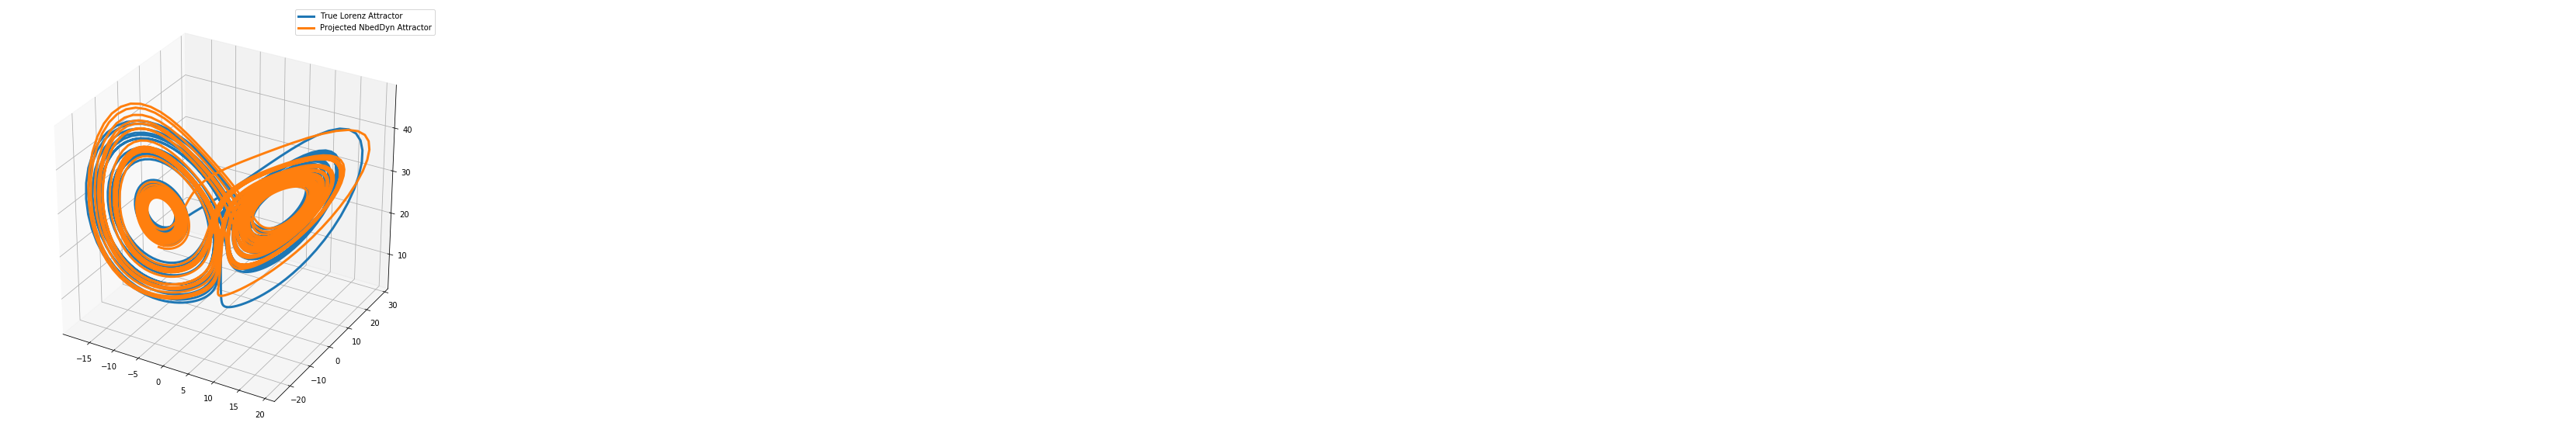

In [40]:
fig = plt.figure(figsize=(10, 10))
ax=fig.gca(projection='3d')
line1,=ax.plot(Attractor_Lorenz[:,0],Attractor_Lorenz[:,1],Attractor_Lorenz[:,2],lw = 3)
line2,=ax.plot(Attractor_Nbed_Dyn3_projected[:,0],Attractor_Nbed_Dyn3_projected[:,1],Attractor_Nbed_Dyn3_projected[:,2],lw = 3)
plt.legend([line1, line2], ['True Lorenz Attractor', 'Projected NbedDyn Attractor'])
plt.grid()